## Pós-Graduação CDS - Interpretabilidade de ML com Shap

### Bibliotecas

In [288]:
import yaml
import pandas                   as pd
import numpy                    as np
import seaborn                  as sns
import statsmodels.formula.api  as smf


from IPython.core.display       import HTML
from IPython.display            import Image

from matplotlib                 import pyplot as plt
from scipy                      import stats
from sklearn                    import metrics
from sklearn.linear_model       import LogisticRegression
from sklearn.tree               import DecisionTreeClassifier
from sklearn.ensemble           import RandomForestClassifier
from sklearn.model_selection    import train_test_split, StratifiedKFold
from sklearn.preprocessing      import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.feature_selection  import SelectKBest, f_classif
from sklearn.compose            import ColumnTransformer
from sklearn.pipeline           import Pipeline
from feature_engine.encoding    import RareLabelEncoder, MeanEncoder
from feature_engine.selection   import RecursiveFeatureAddition

plt.rcParams['figure.figsize'] = 12,8
pd.set_option('display.max_columns', 30)

### Funções Auxiliares

In [ ]:
def import_config(path_yaml):
    with open(path_yaml) as config_file:
        config=yaml.safe_load(config_file)
    return config

def cramer_v(cm): #correlação entre variáveis categóricas: V de Cramer
    n = cm.sum()
    chi2 = stats.chi2_contingency( cm )[0]                  #calculando o qui quadrado de Peason a partir de uma tabela de contingência
    phi2 = chi2 / n
    r,k = cm.shape
    phi2corr = max( 0, phi2 - (k - 1)*(r - 1) / (n - 1) )   #corrigindo o viés do V de Cramer
    kcorr = k - ((k - 1)**2) / (n - 1) 
    rcorr = r - ((r - 1)**2) / (n - 1)
    
    return np.sqrt( phi2corr / ( min(kcorr - 1, rcorr - 1  ) ) )

def label_pago(x):
    if x == 'sim':
        return 0
    else:
        return 1
    
    
def reamostrar_lr(df, frac):
    x_train_2, x_test_2 = train_test_split(df, 
                                           test_size = 0.2, 
                                           random_state = 42, 
                                           stratify = df['pago'])
    
    sample = x_train_2[x_train_2['pago'] == 0].sample(frac = frac,
                                                      random_state = 42)
    
    x_train_2 = x_train_2.drop(sample.index)
    print(x_train_2['pago'].value_counts(normalize = True))

    x_train = x_train_2.drop('pago', axis = 1)
    y_train = x_train_2['pago']

    x_test = x_test_2.drop('pago', axis = 1)
    y_test = x_test_2['pago']
    
    return x_train, x_train_2, y_train, x_test, y_test

def fs_kbest(x_train, y_train, x_test, y_test, model):
    k_vs_score_0 = [] #armazena os scores da classe 0
    k_vs_score_1 = [] #armazena os scores da classe 0

    for k in range(1, len(x_test.columns) + 1, 1):

        '''Função que aplica o SelectKBest ANOVA para seleção de variáveis'''

        selector = SelectKBest(score_func = f_classif, k = k)

        Xtrain2 = selector.fit_transform(x_train, y_train)
        Xval2 = selector.transform(x_test)

        model.fit(Xtrain2, y_train)

        p = model.predict(Xval2)

        score_0 = round(metrics.f1_score(y_test, p, average = None)[0],3)
        score_1 = round(metrics.f1_score(y_test, p, average = None)[1],3)

        print("k= {} 0 F1_0 = {} - F1_1 = {}".format(k, score_0, score_1))

        k_vs_score_0.append(score_0)
        k_vs_score_1.append(score_1)

    pd.Series(k_vs_score_0, index=range(1, len(x_train.columns)+1,1)).plot(figsize=(10,7))
    pd.Series(k_vs_score_1, index=range(1, len(x_train.columns)+1,1)).plot(figsize=(10,7))

    plt.title('VISUALIZING METRIC', fontsize=10, weight='bold')
    plt.ylabel("F1 SCORE", fontsize=10, weight='bold')
    plt.xlabel("QTD FEATURES", fontsize=10, weight='bold')

    plt.show()

    selector = SelectKBest(score_func = f_classif, k=len(x_train.columns))
    selector.fit(x_train, y_train)

    pd.Series(selector.scores_, index=x_train.columns).sort_values().plot.barh()
    
    plt.show()

    df_score = pd.DataFrame({'variavel':x_train.columns, 'fs_score':selector.scores_, 'p_value': selector.pvalues_})
    df_score = df_score.sort_values('fs_score', ascending=False).reset_index(drop=True)
    display(df_score)

In [391]:
def cv_clf_metrics(model, df, target, cv, model_name, search=False):

    X = df.drop(columns=[target])
    y = df[target]

    label_metrics = {
        "accuracy": metrics.accuracy_score,
        "balanced_accuracy": metrics.balanced_accuracy_score,
        "precision_0": lambda yt, yp: metrics.precision_score(yt, yp, pos_label=0),
        "precision_1": lambda yt, yp: metrics.precision_score(yt, yp, pos_label=1),
        "recall_0": lambda yt, yp: metrics.recall_score(yt, yp, pos_label=0),
        "recall_1": lambda yt, yp: metrics.recall_score(yt, yp, pos_label=1),
        "f1_0": lambda yt, yp: metrics.f1_score(yt, yp, pos_label=0),
        "f1_1": lambda yt, yp: metrics.f1_score(yt, yp, pos_label=1),
    }

    proba_metrics = {
        "roc_auc": metrics.roc_auc_score
    }

    train_metrics = {k: [] for k in (*label_metrics, *proba_metrics)}
    test_metrics  = {k: [] for k in (*label_metrics, *proba_metrics)}

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        if not search:
            model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred  = model.predict(X_test)

        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_proba  = model.predict_proba(X_test)[:, 1]

        # métricas baseadas em rótulo
        for name, fn in label_metrics.items():
            train_metrics[name].append(float(fn(y_train, y_train_pred)))
            test_metrics[name].append(float(fn(y_test, y_test_pred)))

        # métricas baseadas em probabilidade
        for name, fn in proba_metrics.items():
            train_metrics[name].append(float(fn(y_train, y_train_proba)))
            test_metrics[name].append(float(fn(y_test, y_test_proba)))

    def summarize(metrics_dict):
        return {
            k: {
                "values": [round(v, 3) for v in vals],
                "mean": round(float(np.mean(vals)), 3),
                "std": round(float(np.std(vals)), 3)
            }
            for k, vals in metrics_dict.items()
        }

    train_summary = summarize(train_metrics)
    test_summary  = summarize(test_metrics)

    def print_block(title, summary):
        print(title)
        for k, v in summary.items():
            print(f"{k:<18}: {v['values']} / media: {v['mean']} / std: {v['std']}")

    print_block("TRAIN DATA", train_summary)
    print("\n" + "-" * 90 + "\n")
    print_block("TEST DATA", test_summary)

    result = pd.DataFrame({
        "Model Name": [model_name],
        "Accuracy CV": f"{test_summary['accuracy']['mean']} +/- {test_summary['accuracy']['std']}",
        "Balanced Accuracy CV": f"{test_summary['balanced_accuracy']['mean']} +/- {test_summary['balanced_accuracy']['std']}",
        "ROC AUC CV": f"{test_summary['roc_auc']['mean']} +/- {test_summary['roc_auc']['std']}",
        "F1 Class 0 CV": f"{test_summary['f1_0']['mean']} +/- {test_summary['f1_0']['std']}",
        "F1 Class 1 CV": f"{test_summary['f1_1']['mean']} +/- {test_summary['f1_1']['std']}",
        "Precision Class 0 CV": f"{test_summary['precision_0']['mean']} +/- {test_summary['precision_0']['std']}",
        "Precision Class 1 CV": f"{test_summary['precision_1']['mean']} +/- {test_summary['precision_1']['std']}",
        "Recall Class 0 CV": f"{test_summary['recall_0']['mean']} +/- {test_summary['recall_0']['std']}",
        "Recall Class 1 CV": f"{test_summary['recall_1']['mean']} +/- {test_summary['recall_1']['std']}",
    })

    display(result)
    return result

### 1.0 Importando os Dados e Arquivo config.yaml

#### 1.1 Config

In [290]:
config = import_config('config.yaml')

In [291]:
config

{'data': {'raw_path': '../data/raw/raw_data.csv',
  'trusted_path': '../data/trusted/trusted_data.csv',
  'train_path': '../data/train_data/train_data.csv',
  'test_path': '../data/test_data/test_data.csv'},
 'imagem': {'path': '../imagens/mapa_mental.png'}}

In [292]:
config['data']['raw_path']

'../data/raw/raw_data.csv'

#### 1.2 Dados

In [293]:
df1 = pd.read_csv(config['data']['raw_path'])

### 2.0 Limpeza dos Dados

In [294]:
df2 = df1.copy()

#### 2.1 Descrição dos Dados

In [295]:
df2.head().T

,0,1,2,3,4
escolaridade,NaN,nivel medio,nivel medio,NaN,NaN
renda_mensal_informal,NaN,1894.5078,NaN,NaN,NaN
dependentes,S,N,S,N,S
estado_civil,solteiro,solteiro,solteiro,casado(a) com comunhao de bens,solteiro
idade,36,39,26,23,33
conta_poupanca,S,S,S,N,S
conta_salario,N,N,N,N,N
qtd_fonte_renda,NaN,1.0,1.0,NaN,NaN
cheque_sem_fundo,S,N,N,S,S
conta_conjunta,N,N,N,N,N


#### 2.2 Dimensão dos Dados

In [296]:
df2.shape

(50390, 21)

#### 2.3 Tipo das colunas

In [297]:
df2.info()

<class 'pandas.DataFrame'>
RangeIndex: 50390 entries, 0 to 50389
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   escolaridade                 14615 non-null  str    
 1   renda_mensal_informal        9768 non-null   float64
 2   dependentes                  50390 non-null  str    
 3   estado_civil                 50390 non-null  str    
 4   idade                        50390 non-null  int64  
 5   conta_poupanca               50390 non-null  str    
 6   conta_salario                50390 non-null  str    
 7   qtd_fonte_renda              12806 non-null  float64
 8   cheque_sem_fundo             50390 non-null  str    
 9   conta_conjunta               50390 non-null  str    
 10  valor_conta_corrente         0 non-null      float64
 11  valor_conta_poupanca         0 non-null      float64
 12  valor_emprestimo             50390 non-null  float64
 13  multa                      

#### 2.4 Verificando Dados Nulos

In [298]:
df2.isna().sum() / len(df2)

escolaridade                   0.709962
renda_mensal_informal          0.806152
dependentes                    0.000000
estado_civil                   0.000000
idade                          0.000000
conta_poupanca                 0.000000
conta_salario                  0.000000
qtd_fonte_renda                0.745862
cheque_sem_fundo               0.000000
conta_conjunta                 0.000000
valor_conta_corrente           1.000000
valor_conta_poupanca           1.000000
valor_emprestimo               0.000000
multa                          0.000000
juros                          0.000000
valor_emprestimo_atualizado    0.000000
pago                           0.000000
id                             0.000000
genero                         0.000000
data                           0.000000
estado                         0.000000
dtype: float64

#### 2.5 Excluir Linhas Duplicadas

In [299]:
df2.drop_duplicates().shape

(50390, 21)

#### 2.6 Mudar o Tipo da Variável

In [300]:
df2['data'] = df2['data'].astype('datetime64[ns]')

#### 2.7 Excluir colunas com dados nulos

In [301]:
#Colunas com 100% dos dados nulos:
df2 = df2.drop(['valor_conta_corrente', 'valor_conta_poupanca'], axis = 1)

In [302]:
#colunas com muitos dados nulos:
df2 = df2.drop(['escolaridade', 'renda_mensal_informal', 'qtd_fonte_renda'], axis = 1)

In [303]:
#excluir coluna 'data' que contém apenas uma data única: ['2020-01-01 00:00:00']
df2 = df2.drop(['data'], axis = 1)

#### 2.8 Estatística Descritiva

In [304]:
num_attributes = df2.select_dtypes(include = ['int32', 'int64', 
                                   'float32', 'float64'])

cat_attributes = df2.select_dtypes(exclude = ['int32', 'int64', 
                                   'float32', 'float64', 'datetime64[ns]'])

##### 2.8.1 Variáveis Numéricas

In [305]:
#Tendência central:

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T          #média
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T        #mediana  

#Dispersão:

d1 = pd.DataFrame(num_attributes.apply(np.std)).T                          #desvio-padrão
d2 = pd.DataFrame(num_attributes.apply(min)).T                             #mínimo
d3 = pd.DataFrame(num_attributes.apply(max)).T                             #máximo
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T     #range
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T              #skew 
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T          #kurtosis

#Concatenar:

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

m.head()

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,idade,18.00,1.130000e+02,9.500000e+01,31.724529,30.000,8.565032e+00,1.959951,7.223175
1,valor_emprestimo,1393.00,2.867894e+08,2.867880e+08,51988.873901,2298.035,1.588803e+06,135.859233,22605.724510
2,multa,0.00,5.737759e+08,5.737759e+08,60226.580975,648.965,2.843913e+06,171.305766,33333.600930
3,juros,0.00,5.703619e+08,5.703619e+08,64853.905193,1143.320,2.728143e+06,184.431138,38002.805365
4,valor_emprestimo_atualizado,1397.04,1.430927e+09,1.430926e+09,177069.360068,5652.695,7.058294e+06,171.822788,33820.743108


In [306]:
num_attributes.describe(percentiles=[0.99, 0.95, 0.75, 0.5]).T

,count,mean,std,min,50%,75%,95%,99%,max
idade,50390.0,3.172453e+01,8.565117e+00,1.800000e+01,3.000000e+01,3.500000e+01,4.800000e+01,6.200000e+01,1.130000e+02
valor_emprestimo,50390.0,5.198887e+04,1.588819e+06,1.393000e+03,2.298035e+03,7.172175e+03,5.879202e+04,4.464769e+05,2.867894e+08
multa,50390.0,6.022658e+04,2.843941e+06,0.000000e+00,6.489650e+02,3.600000e+03,6.189092e+04,5.039267e+05,5.737759e+08
juros,50390.0,6.485391e+04,2.728170e+06,0.000000e+00,1.143320e+03,5.545427e+03,8.235361e+04,6.408426e+05,5.703619e+08
valor_emprestimo_atualizado,50390.0,1.770694e+05,7.058364e+06,1.397040e+03,5.652695e+03,1.903061e+04,2.006742e+05,1.586720e+06,1.430927e+09
id,50390.0,5.485969e+08,2.601500e+08,1.000172e+08,5.482058e+08,7.737146e+08,9.542667e+08,9.912031e+08,9.999988e+08


##### 2.8.2. Variáveis Categóricas

In [307]:
for i in cat_attributes.columns:
    print(cat_attributes[i].value_counts(normalize=True))
    print('===================================================\n\n')

dependentes
N    0.639968
S    0.360032
Name: proportion, dtype: float64


estado_civil
solteiro                                  0.547053
casado(a) com comunhao parcial de bens    0.263604
casado(a) com comunhao de bens            0.154098
casado(a) com separacao de bens           0.030959
separado judicialmente                    0.001469
divorciado                                0.001330
viuvo(a)                                  0.000814
outros                                    0.000675
Name: proportion, dtype: float64


conta_poupanca
S    0.847986
N    0.152014
Name: proportion, dtype: float64


conta_salario
N    0.976603
S    0.023397
Name: proportion, dtype: float64


cheque_sem_fundo
S    0.769974
N    0.230026
Name: proportion, dtype: float64


conta_conjunta
N    0.958285
S    0.041715
Name: proportion, dtype: float64


pago
sim    0.790891
nao    0.209109
Name: proportion, dtype: float64


genero
masculino    0.501667
feminino     0.498333
Name: proportion, dtype: float64


### 3.0 Mapa Mental de Hipóteses e Engenharia de Variáveis

In [308]:
df3 = df2.copy()

#### 3.1 Mapa Mental de Hipóteses

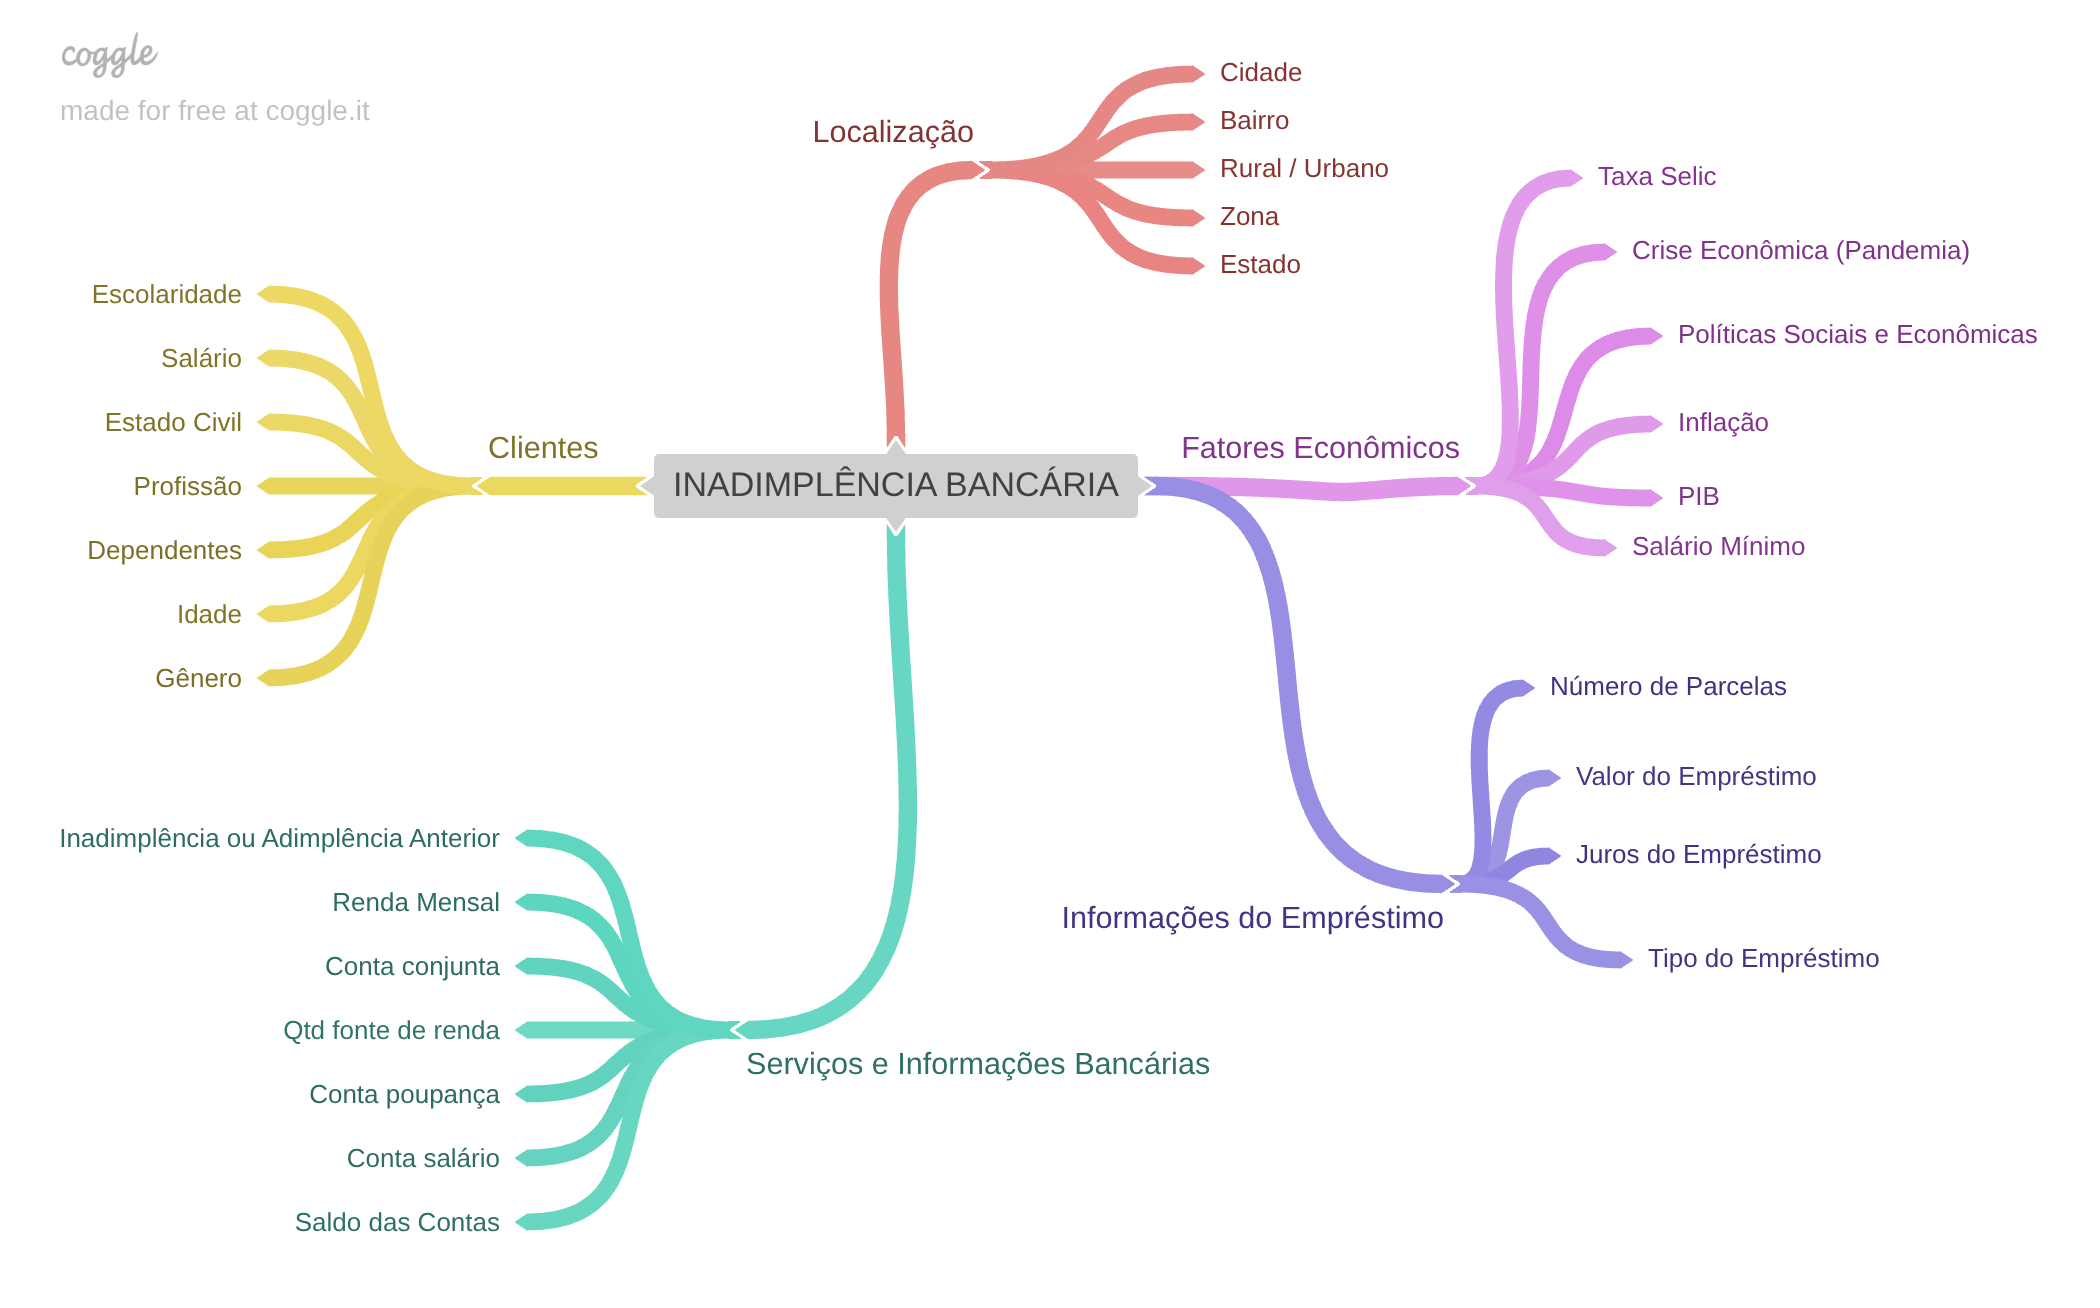

In [309]:
Image(config['imagem']['path'])

##### Hipóteses dos Clientes:

1. Mulheres são em média 10% mais ADIMPLENTES
2. Clientes com menos de 60 anos são em média 20% mais ADIMPLENTES
3. Clientes com dependentes são em média 15% mais ADIMPLENTES
4. Clientes solteiros tem uma taxa percentual maior de INADIMPLÊNCIA do que os demais

##### Hipóteses de Informações Bancárias:

5. Clientes com conta salário são em média 30% mais ADIMPLENTES
6. Clientes com conta poupança são em média 10% mais ADIMPLENTES
7. Clientes que já passaram cheque sem fundo são em média 15% mais INADIMPLENTES
8. Clientes que tem conta conjunta são em média 10% mais INADIMPLENTES

##### Hipóteses de Informações do Empréstimo:

9. Clientes que pegaram empréstimos de mais de R$ 20.000,00 tem tendência a serem INADIMPLENTES

##### Hipóteses da Localização:

10. Os estados de RJ e SP tem maior percentual de clientes ADIMPLENTES do que ES e MG

#### 3.2 Engenharia de Variáveis

In [310]:
len(df3['id'].unique())

50390

In [311]:
df3.shape

(50390, 15)

In [312]:
#juros:

df3['juros_porcentagem'] = df3['juros'] / df3['valor_emprestimo']

### 4.0 EDA Univariada

In [313]:
df4 = df3.copy()

#### 4.1 Variáveis Numéricas

In [314]:
num_attributes = df4.select_dtypes(include = ['int32', 'int64', 
                                   'float32', 'float64'])

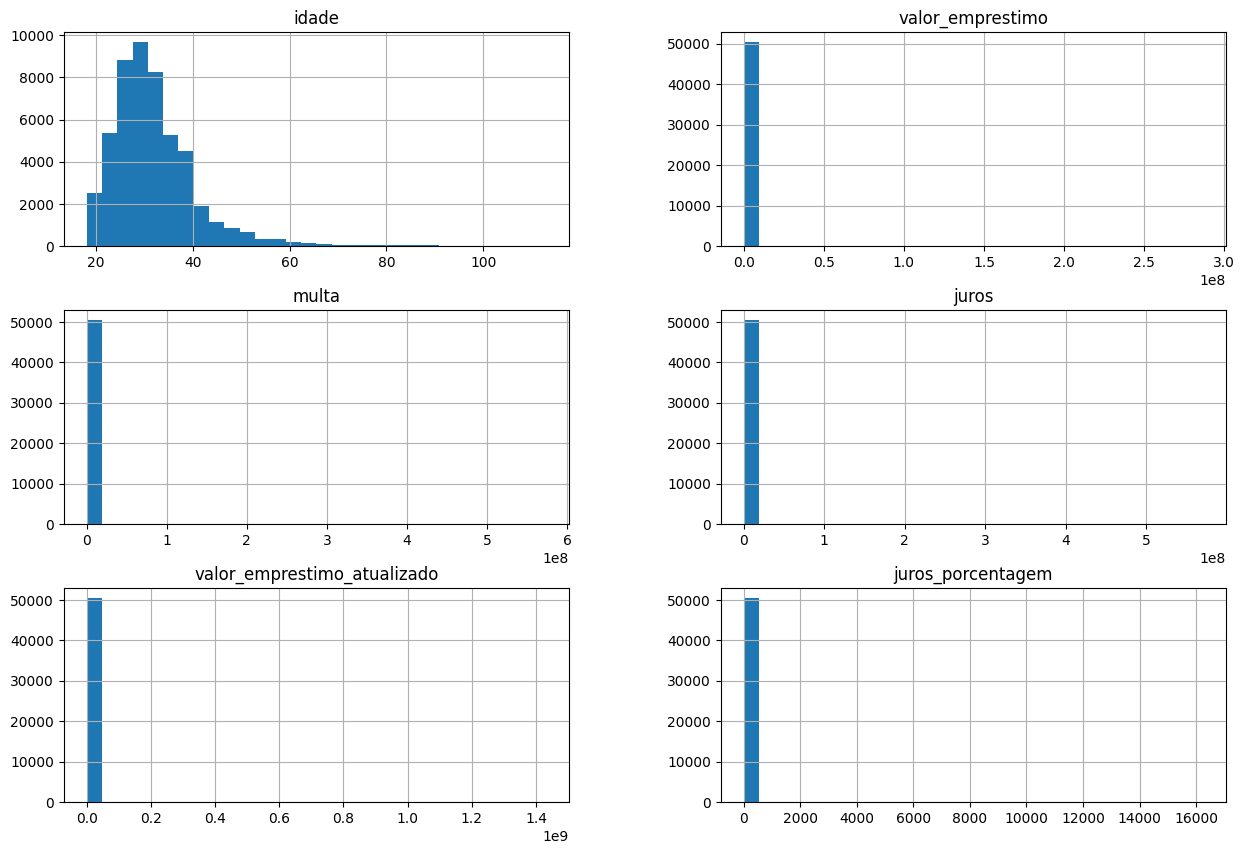

In [315]:
num_attributes.drop('id', axis = 1).hist(bins = 30, figsize = (15,10));

##### 4.1.1 Idade

count    50390.000000
mean        31.724529
std          8.565117
min         18.000000
25%         26.000000
50%         30.000000
75%         35.000000
max        113.000000
Name: idade, dtype: float64


Text(0.5, 1.0, 'Boxplot')

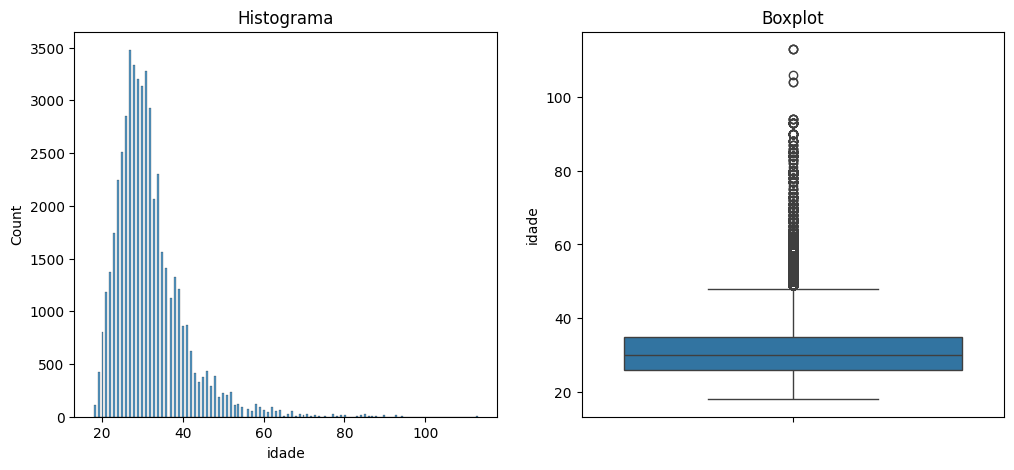

In [316]:
print(df4['idade'].describe())

fig, axes = plt.subplots(1,2 ,figsize = (12,5))

sns.histplot(df4['idade'], ax=axes[0])
axes[0].set_title('Histograma')

sns.boxplot(df4['idade'], ax=axes[1])
axes[1].set_title('Boxplot')

##### 4.1.2 Valor do Empréstimo

count    5.039000e+04
mean     5.198887e+04
std      1.588819e+06
min      1.393000e+03
25%      1.622370e+03
50%      2.298035e+03
75%      7.172175e+03
max      2.867894e+08
Name: valor_emprestimo, dtype: float64


Text(0.5, 1.0, 'Boxplot')

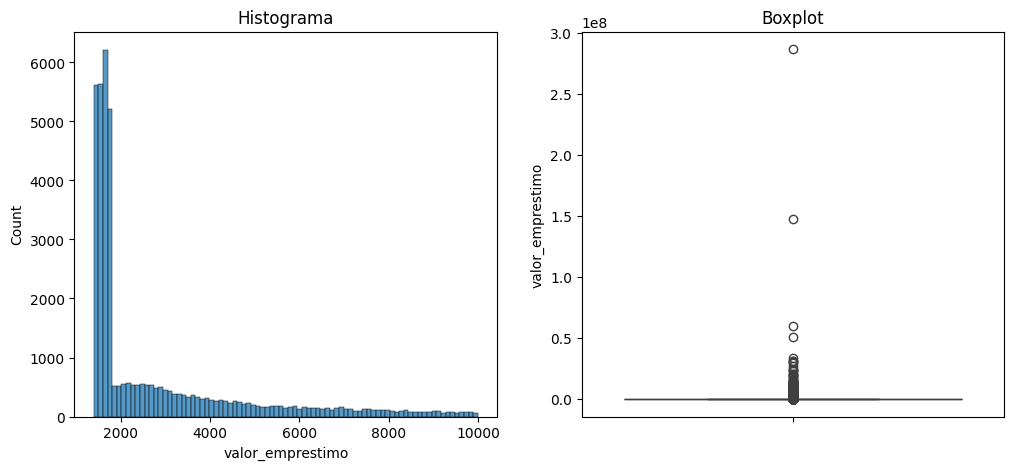

In [317]:
print(df4['valor_emprestimo'].describe())

fig, axes = plt.subplots(1,2 ,figsize = (12,5))

sns.histplot(df4[df4['valor_emprestimo'] < 10000]['valor_emprestimo'], ax=axes[0])
axes[0].set_title('Histograma')

sns.boxplot(df4['valor_emprestimo'], ax=axes[1])
axes[1].set_title('Boxplot')

##### 4.1.3 Multa

count    5.039000e+04
mean     6.022658e+04
std      2.843941e+06
min      0.000000e+00
25%      1.325675e+02
50%      6.489650e+02
75%      3.600000e+03
max      5.737759e+08
Name: multa, dtype: float64


Text(0.5, 1.0, 'Boxplot')

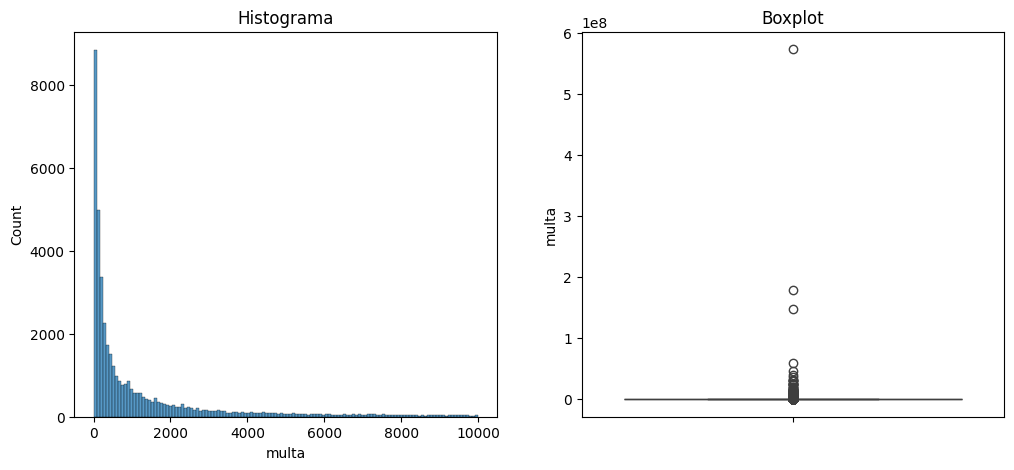

In [318]:
print(df4['multa'].describe())

fig, axes = plt.subplots(1,2 ,figsize = (12,5))

sns.histplot(df4[df4['multa'] < 10000]['multa'], ax=axes[0])
axes[0].set_title('Histograma')

sns.boxplot(df4['multa'], ax=axes[1])
axes[1].set_title('Boxplot')

##### 4.1.4 Juros

count    5.039000e+04
mean     6.485391e+04
std      2.728170e+06
min      0.000000e+00
25%      2.742725e+02
50%      1.143320e+03
75%      5.545427e+03
max      5.703619e+08
Name: juros, dtype: float64


Text(0.5, 1.0, 'Boxplot')

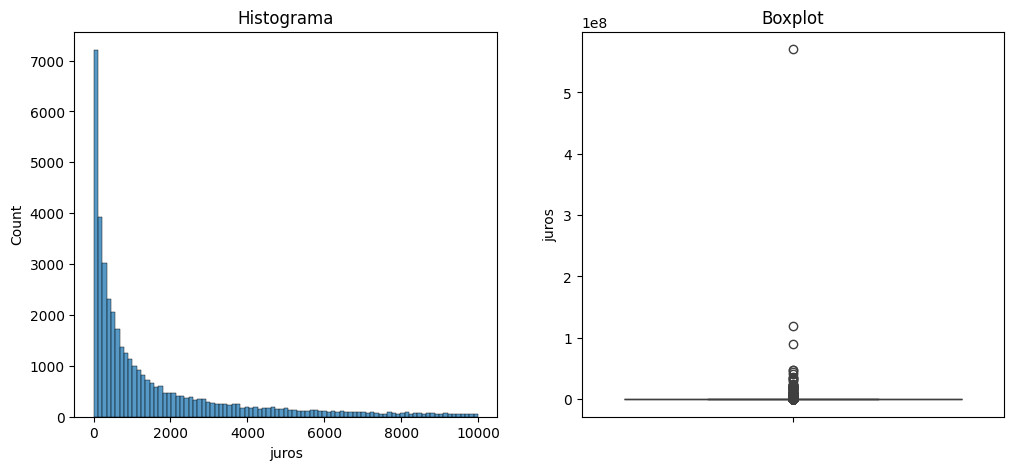

In [319]:
print(df4['juros'].describe())

fig, axes = plt.subplots(1,2 ,figsize = (12,5))

sns.histplot(df4[df4['juros'] < 10000]['juros'], ax=axes[0])
axes[0].set_title('Histograma')

sns.boxplot(df4['juros'], ax=axes[1])
axes[1].set_title('Boxplot')

##### 4.1.5 Valor do Empréstimo Atualizado

count    5.039000e+04
mean     1.770694e+05
std      7.058364e+06
min      1.397040e+03
25%      2.842910e+03
50%      5.652695e+03
75%      1.903061e+04
max      1.430927e+09
Name: valor_emprestimo_atualizado, dtype: float64


Text(0.5, 1.0, 'Boxplot')

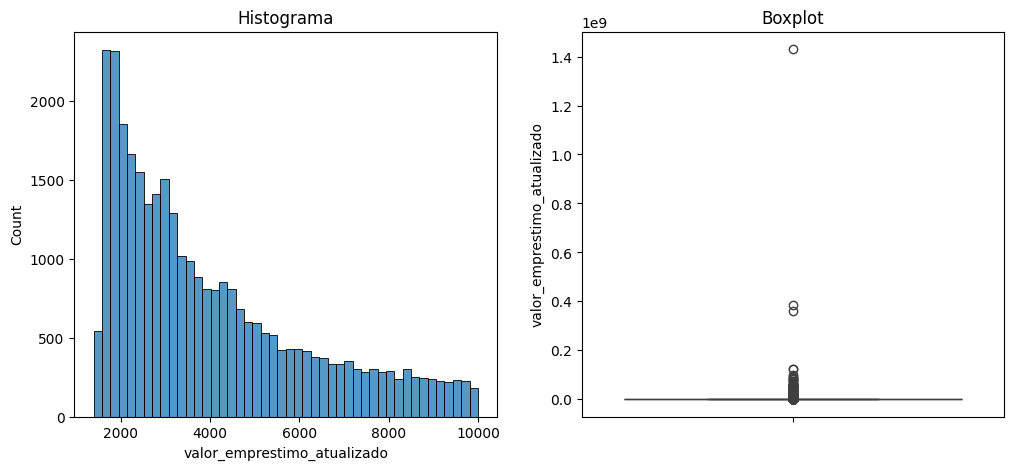

In [320]:
print(df4['valor_emprestimo_atualizado'].describe())

fig, axes = plt.subplots(1,2 ,figsize = (12,5))

sns.histplot(df4[df4['valor_emprestimo_atualizado'] < 10000]['valor_emprestimo_atualizado'], ax=axes[0])
axes[0].set_title('Histograma')

sns.boxplot(df4['valor_emprestimo_atualizado'], ax=axes[1])
axes[1].set_title('Boxplot')

##### 4.1.6 Juros Percentual

count    50390.000000
mean         3.029730
std        105.423189
min          0.000000
25%          0.112590
50%          0.349677
75%          0.848668
max      16248.020882
Name: juros_porcentagem, dtype: float64


Text(0.5, 1.0, 'Boxplot')

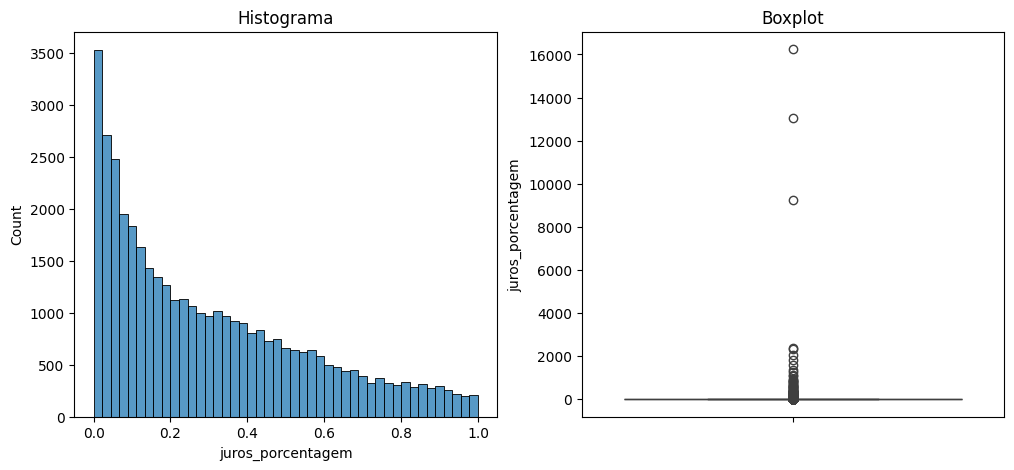

In [321]:
print(df4['juros_porcentagem'].describe())

fig, axes = plt.subplots(1,2 ,figsize = (12,5))

sns.histplot(df4[df4['juros_porcentagem'] < 1]['juros_porcentagem'], ax=axes[0])
axes[0].set_title('Histograma')

sns.boxplot(df4['juros_porcentagem'], ax=axes[1])
axes[1].set_title('Boxplot')

#### 4.2 Variáveis Categóricas

##### 4.2.1 Dependentes

dependentes
N    0.639968
S    0.360032
Name: proportion, dtype: float64


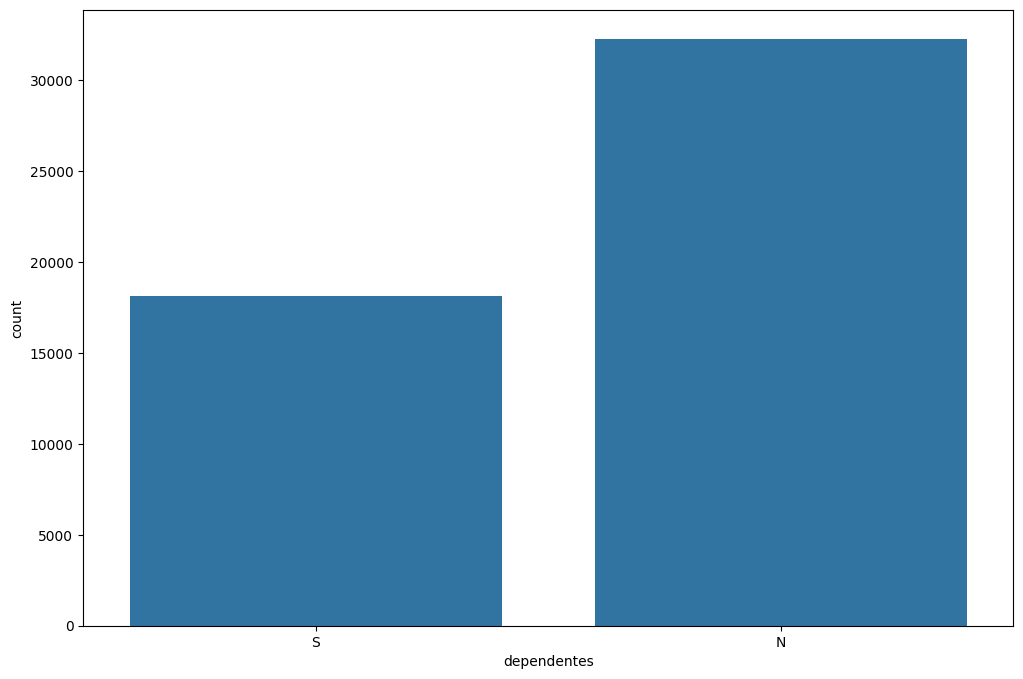

In [322]:
print(df4['dependentes'].value_counts(normalize = True))

sns.countplot(x = 'dependentes', data = df4);

##### 4.2.2 Estado Civil

estado_civil
solteiro                                  0.547053
casado(a) com comunhao parcial de bens    0.263604
casado(a) com comunhao de bens            0.154098
casado(a) com separacao de bens           0.030959
separado judicialmente                    0.001469
divorciado                                0.001330
viuvo(a)                                  0.000814
outros                                    0.000675
Name: proportion, dtype: float64


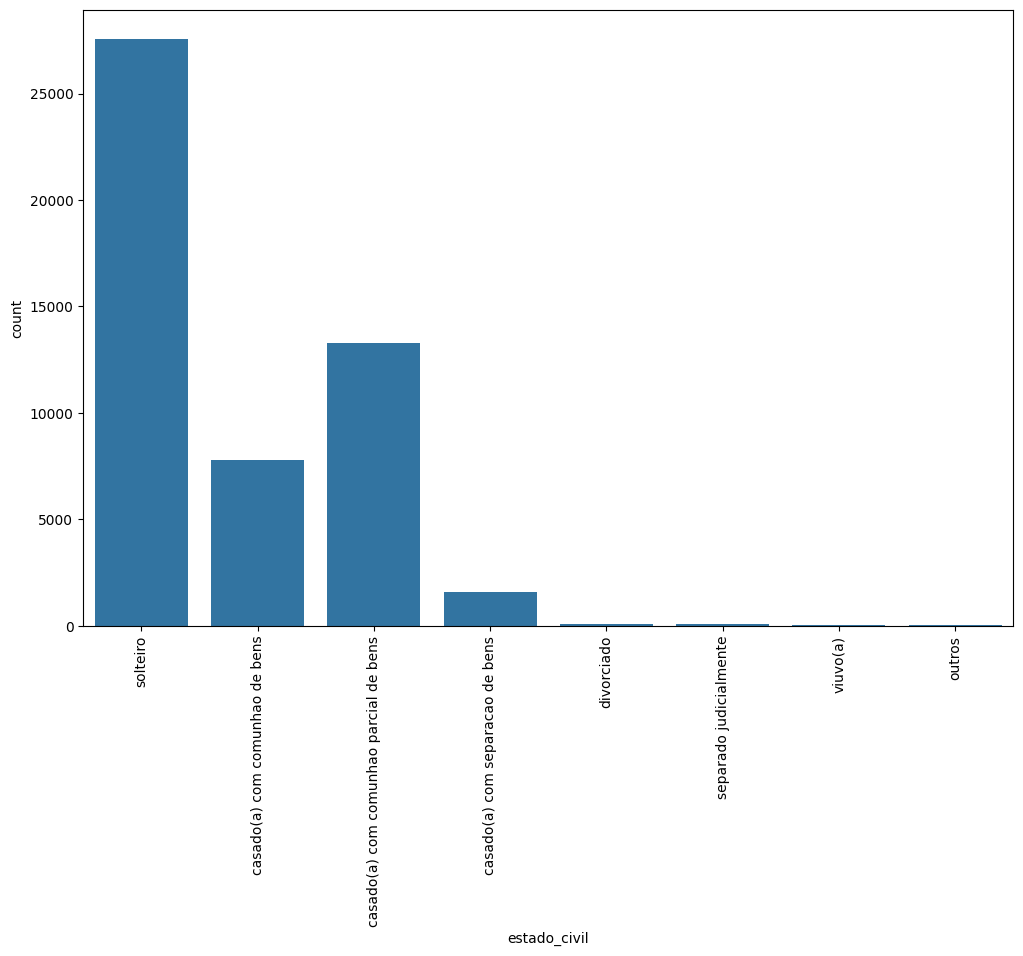

In [323]:
print(df4['estado_civil'].value_counts(normalize = True))

sns.countplot(x = 'estado_civil', data = df4)
plt.xticks(rotation = 90);

##### 4.2.3 Conta Poupança

conta_poupanca
S    0.847986
N    0.152014
Name: proportion, dtype: float64


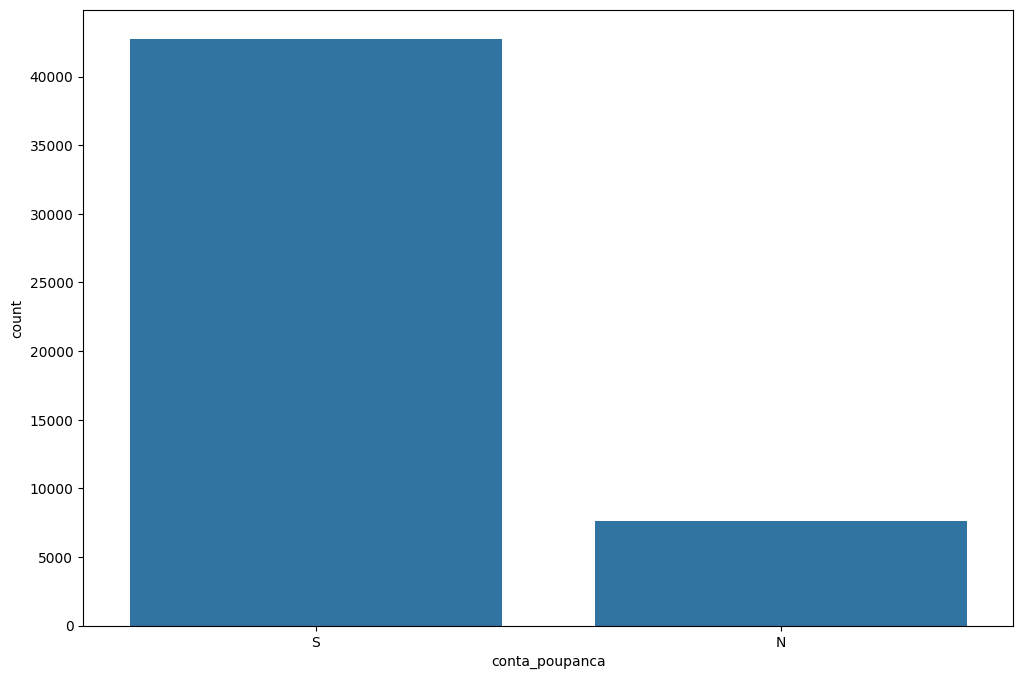

In [324]:
print(df4['conta_poupanca'].value_counts(normalize = True))

sns.countplot(x = 'conta_poupanca', data = df4);

##### 4.2.4 Conta Salário

conta_salario
N    0.976603
S    0.023397
Name: proportion, dtype: float64


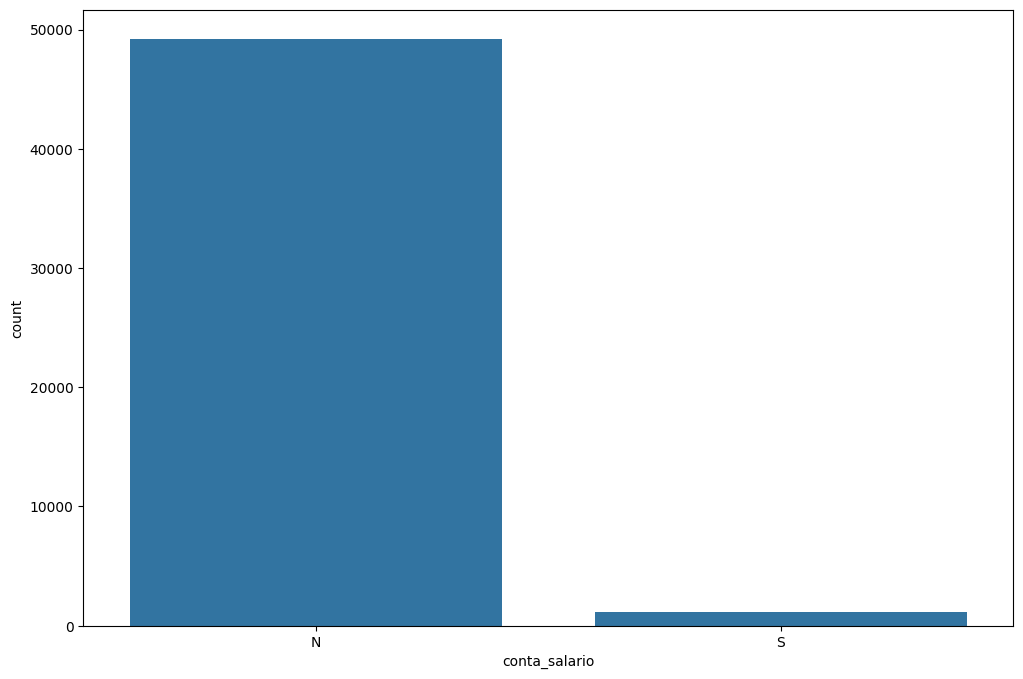

In [325]:
print(df4['conta_salario'].value_counts(normalize = True))

sns.countplot(x = 'conta_salario', data = df4);

##### 4.2.5 Cheque sem fundo

cheque_sem_fundo
S    0.769974
N    0.230026
Name: proportion, dtype: float64


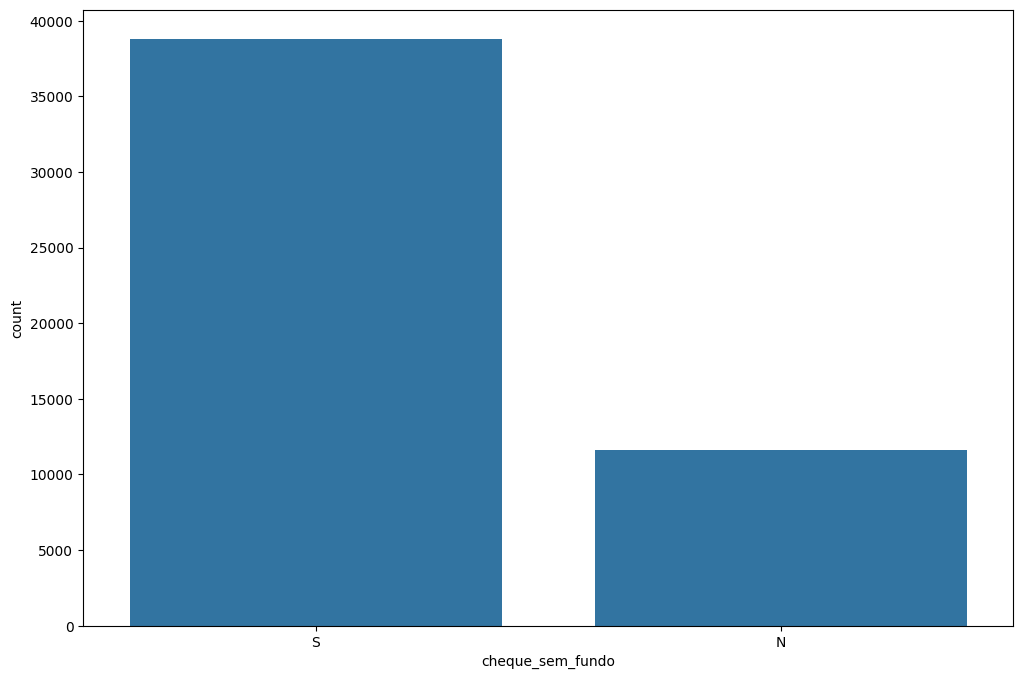

In [326]:
print(df4['cheque_sem_fundo'].value_counts(normalize = True))

sns.countplot(x = 'cheque_sem_fundo', data = df4);

##### 4.2.6 Conta conjunta

conta_conjunta
N    0.958285
S    0.041715
Name: proportion, dtype: float64


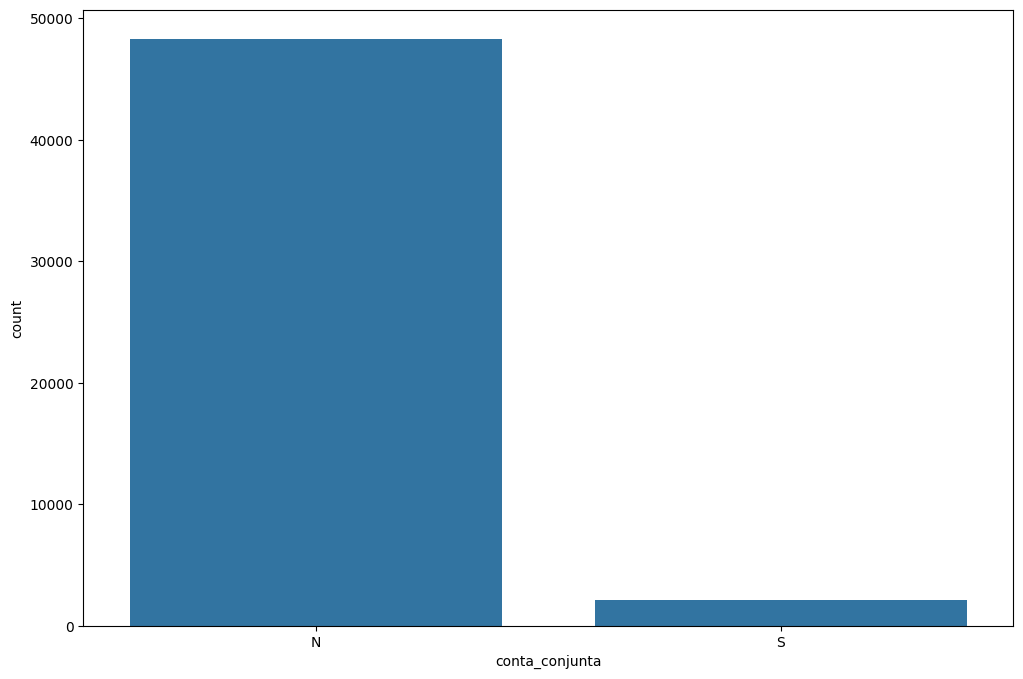

In [327]:
print(df4['conta_conjunta'].value_counts(normalize = True))

sns.countplot(x = 'conta_conjunta', data = df4);

##### 4.2.7 Pago (variável alvo)

pago
sim    0.790891
nao    0.209109
Name: proportion, dtype: float64


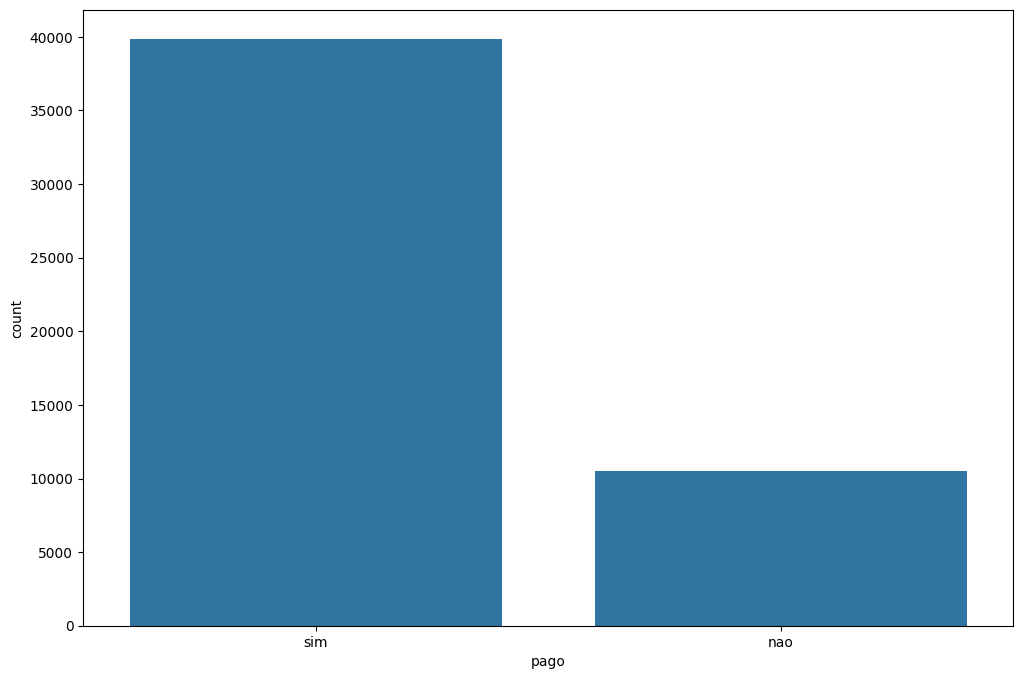

In [328]:
print(df4['pago'].value_counts(normalize = True))

sns.countplot(x = 'pago', data = df4);

##### 4.2.8 Gênero

genero
masculino    0.501667
feminino     0.498333
Name: proportion, dtype: float64


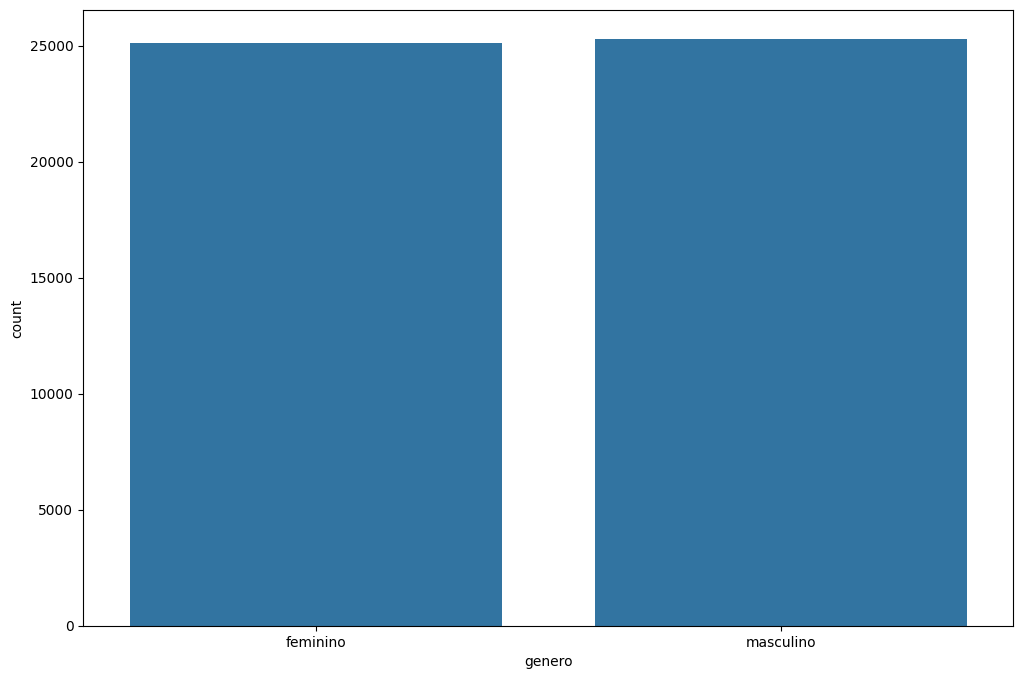

In [329]:
print(df4['genero'].value_counts(normalize = True))

sns.countplot(x = 'genero', data = df4);

##### 4.2.9 Estado

estado
minas gerais      0.251340
sao paulo         0.250189
espirito santo    0.249772
rio de janeiro    0.248700
Name: proportion, dtype: float64


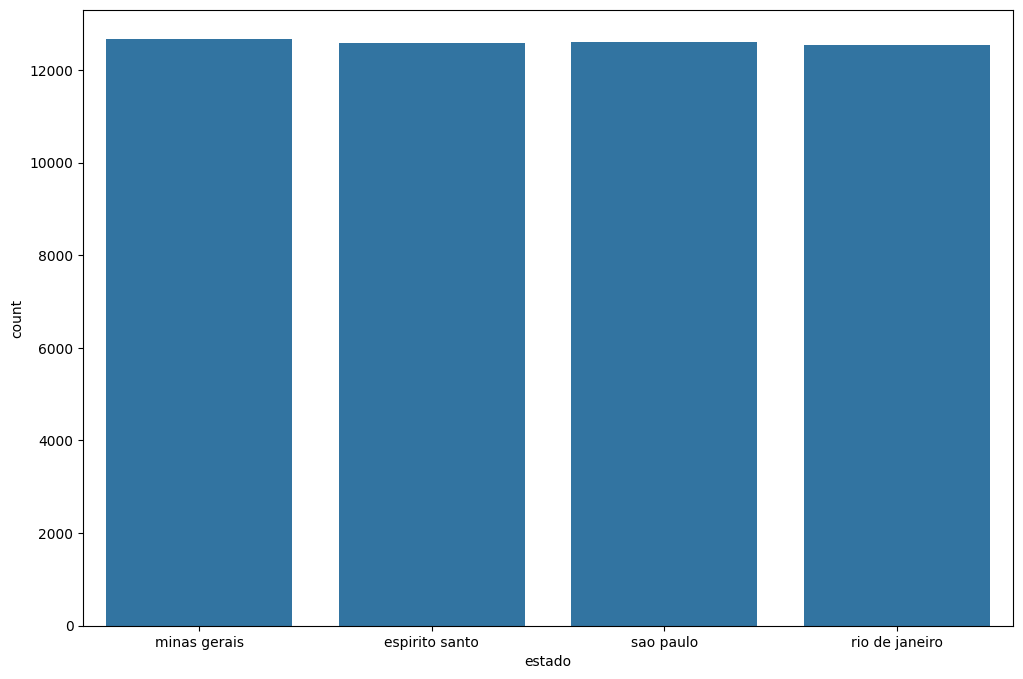

In [330]:
print(df4['estado'].value_counts(normalize = True))

sns.countplot(x = 'estado', data = df4);

### 5.0 Retirando os Outliers

In [331]:
df5 = df4.copy()

In [332]:
df5['pago'].value_counts(normalize = True)

pago
sim    0.790891
nao    0.209109
Name: proportion, dtype: float64

In [333]:
#Qual o percentual da base com empréstimos maiores do que 5 milhões?

len(df5[df5['valor_emprestimo'] > 5000000]) / len(df5)

0.0015479261758285373

In [334]:
#Qual o percentual da base com juros_porcentagem menor do que 0.01 ?

len(df5[df5['juros_porcentagem']<0.01]) / len(df5)

0.03464973208970034

In [335]:
#removendo os outliers:

df5 = df5[df5['valor_emprestimo'] < 5000000].copy()
df5 = df5[df5['juros_porcentagem'] > 0.01].copy()

In [336]:
df5['pago'].value_counts(normalize = True)

pago
sim    0.787073
nao    0.212927
Name: proportion, dtype: float64

In [337]:
df5.to_csv(config['data']['trusted_path'], index = False)

### 6.0 EDA Bivariada

In [338]:
df6 = pd.read_csv(config['data']['trusted_path'])

#### 6.1 GÊNERO: Mulheres são em média 10% mais ADIMPLENTES (FALSA)

pago,nao,sim
genero,,
feminino,5220,18992
masculino,5121,19233


pago,nao,sim
genero,,
feminino,0.215596,0.784404
masculino,0.210273,0.789727


<Axes: xlabel='genero'>

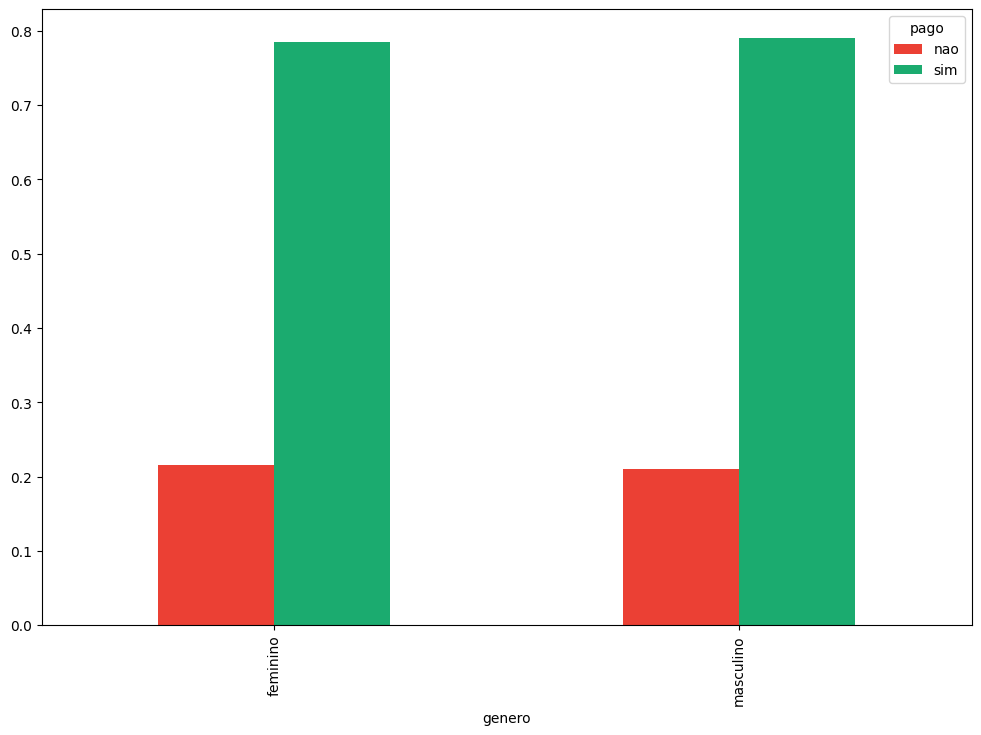

In [339]:
display(pd.crosstab(df6['genero'], df6['pago']))

display(pd.crosstab(df6['genero'], df6['pago'], normalize = 'index'))

display(pd.crosstab(df6['genero'], df6['pago'], normalize = 'index')
        .plot(kind = 'bar', color = {'nao': '#eb4034' , 'sim': '#1bab6f'}));

#### 6.2 IDADE: Clientes com menos de 60 anos são em média 20% mais ADIMPLENTES (FALSA)

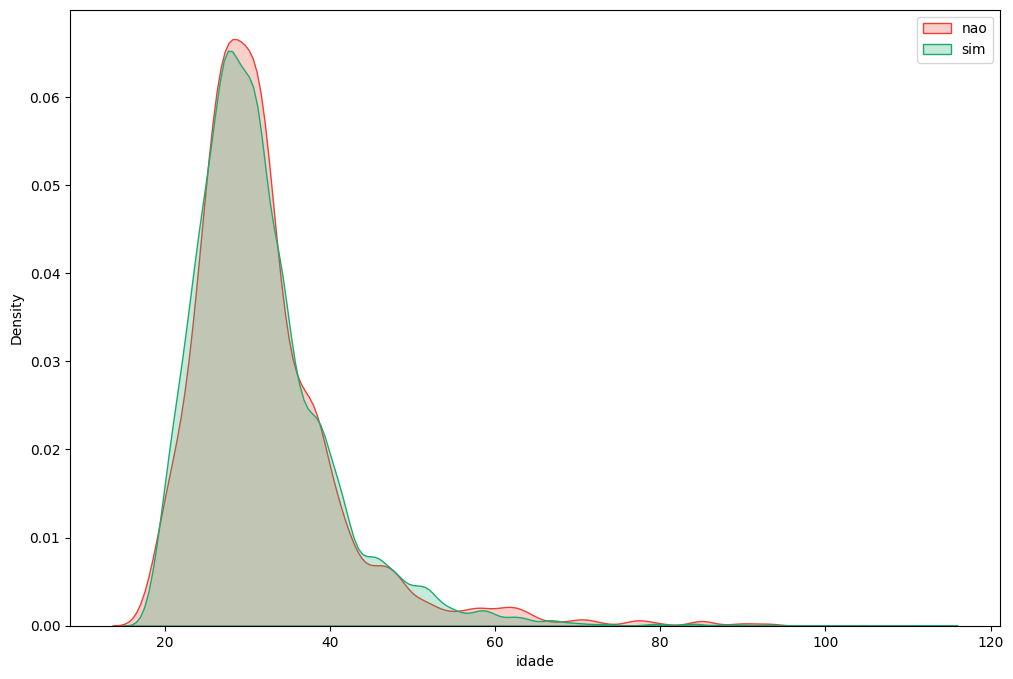

In [340]:
sns.kdeplot(df6[df6['pago'] == 'nao']['idade'], label ='nao', fill = True, color = '#eb4034')
sns.kdeplot(df6[df6['pago'] == 'sim']['idade'], label ='sim', fill = True, color = '#1bab6f')

plt.legend()

In [341]:
bins = list(np.arange(18,113,20))
aux = df6.copy()

aux['idade_bined'] = pd.cut(aux['idade'], bins = bins)

pago,nao,sim
idade_bined,,
"(18, 38]",8715,32015
"(38, 58]",1345,5649
"(58, 78]",193,408
"(78, 98]",46,80


pago,nao,sim
idade_bined,,
"(18, 38]",0.213970,0.786030
"(38, 58]",0.192308,0.807692
"(58, 78]",0.321131,0.678869
"(78, 98]",0.365079,0.634921


<Axes: xlabel='idade_bined'>

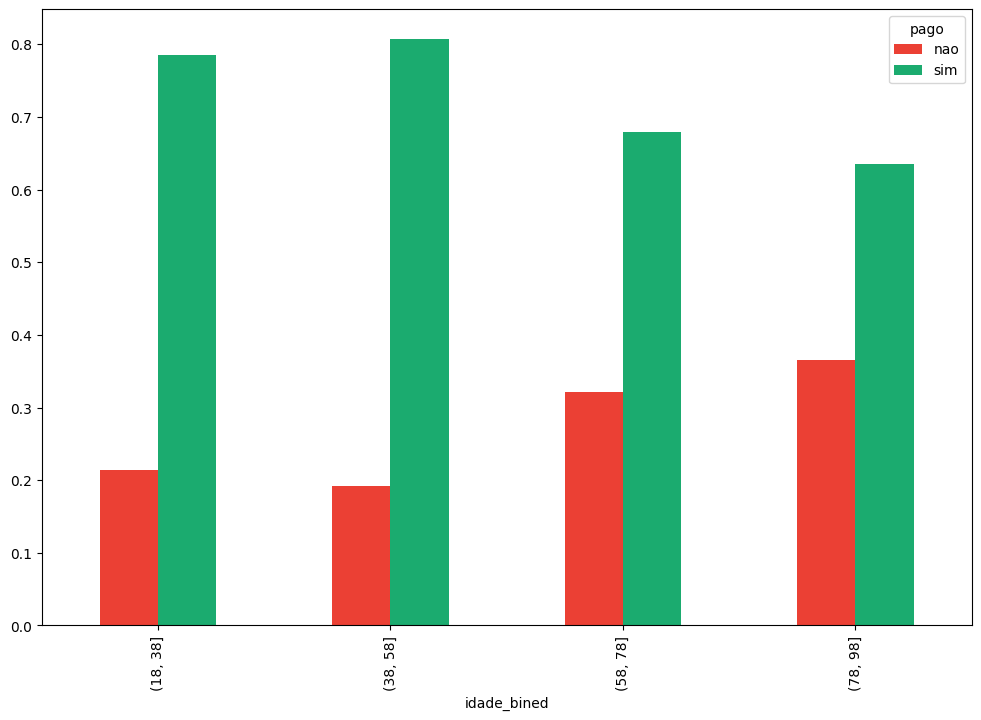

In [342]:
display(pd.crosstab(aux['idade_bined'], aux['pago']))

display(pd.crosstab(aux['idade_bined'], aux['pago'], normalize = 'index'))

display(pd.crosstab(aux['idade_bined'], aux['pago'], normalize = 'index')
        .plot(kind = 'bar', color = {'nao': '#eb4034' , 'sim': '#1bab6f'}));

#### 6.3. DEPENDENTES: Clientes com dependentes são em média 15% mais ADIMPLENTES (VERDADEIRA)

pago,nao,sim
dependentes,,
N,8661,22568
S,1680,15657


pago,nao,sim
dependentes,,
N,0.277338,0.722662
S,0.096903,0.903097


<Axes: xlabel='dependentes'>

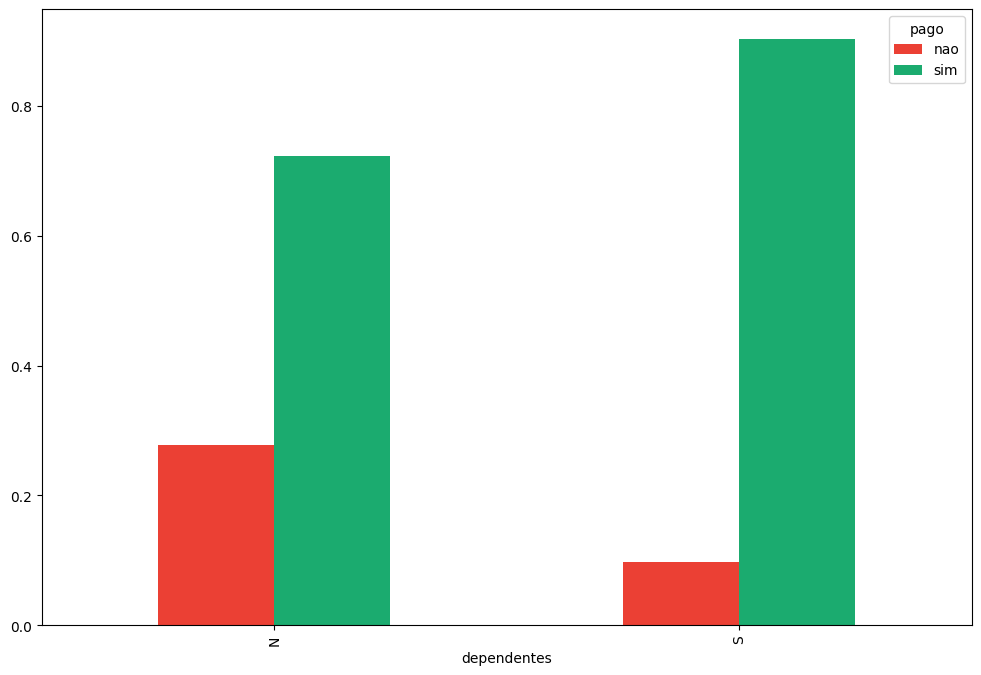

In [343]:
display(pd.crosstab(df6['dependentes'], df6['pago']))

display(pd.crosstab(df6['dependentes'], df6['pago'], normalize = 'index'))

display(pd.crosstab(df6['dependentes'], df6['pago'], normalize = 'index')
        .plot(kind = 'bar', color = {'nao': '#eb4034' , 'sim': '#1bab6f'}));

#### 6.4. ESTADO CIVIL: Clientes solteiros tem uma taxa percentual maior de INADIMPLÊNCIA do que os demais (FALSA)

pago,nao,sim
estado_civil,,
casado(a) com comunhao de bens,1790,5825
casado(a) com comunhao parcial de bens,5112,8003
casado(a) com separacao de bens,401,1105
divorciado,6,56
outros,27,7
separado judicialmente,33,41
solteiro,2949,23170
viuvo(a),23,18


pago,nao,sim
estado_civil,,
casado(a) com comunhao de bens,0.235062,0.764938
casado(a) com comunhao parcial de bens,0.389783,0.610217
casado(a) com separacao de bens,0.266268,0.733732
divorciado,0.096774,0.903226
outros,0.794118,0.205882
separado judicialmente,0.445946,0.554054
solteiro,0.112906,0.887094
viuvo(a),0.560976,0.439024


<Axes: xlabel='estado_civil'>

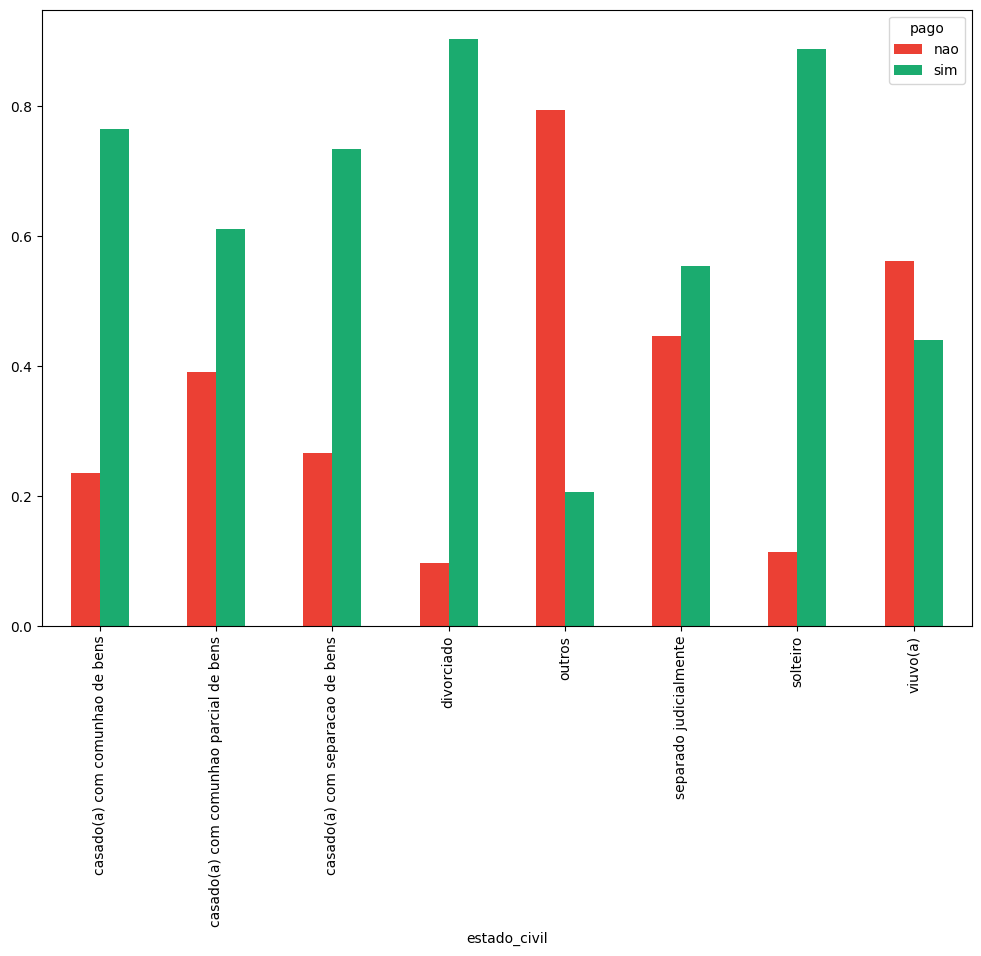

In [344]:
display(pd.crosstab(df6['estado_civil'], df6['pago']))

display(pd.crosstab(df6['estado_civil'], df6['pago'], normalize = 'index'))

display(pd.crosstab(df6['estado_civil'], df6['pago'], normalize = 'index')
        .plot(kind = 'bar', color = {'nao': '#eb4034' , 'sim': '#1bab6f'}));

#### 6.5. CONTA SALÁRIO: Clientes com conta salário são em média 30% mais ADIMPLENTES (FALSA)

In [345]:
df6.columns

Index(['dependentes', 'estado_civil', 'idade', 'conta_poupanca',
       'conta_salario', 'cheque_sem_fundo', 'conta_conjunta',
       'valor_emprestimo', 'multa', 'juros', 'valor_emprestimo_atualizado',
       'pago', 'id', 'genero', 'estado', 'juros_porcentagem'],
      dtype='str')

pago,nao,sim
conta_salario,,
N,10030,37403
S,311,822


pago,nao,sim
conta_salario,,
N,0.211456,0.788544
S,0.274492,0.725508


<Axes: xlabel='conta_salario'>

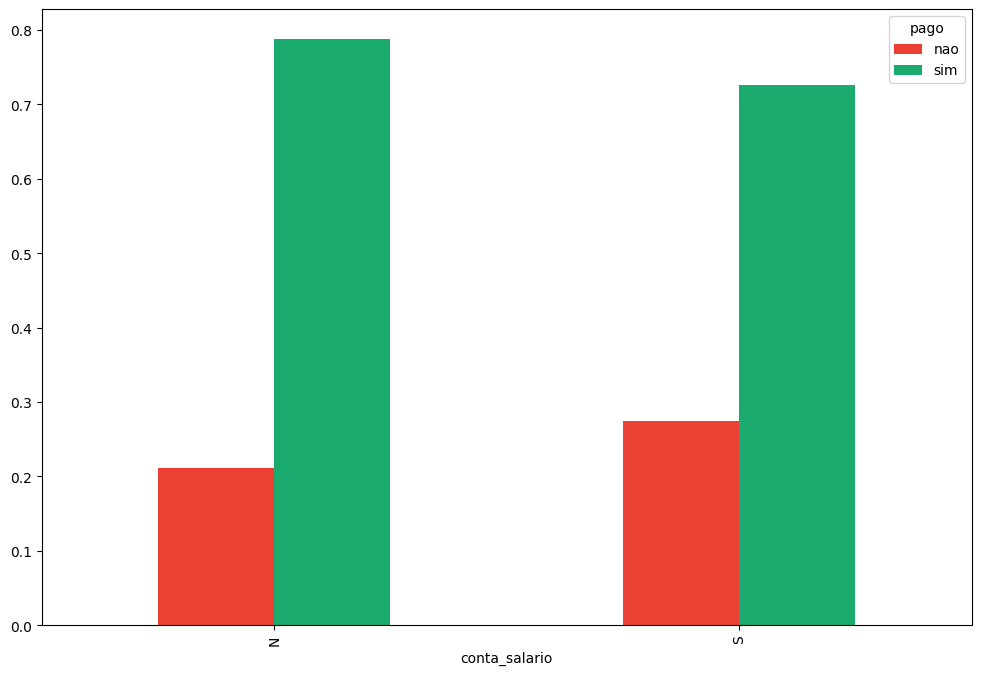

In [346]:
display(pd.crosstab(df6['conta_salario'], df6['pago']))

display(pd.crosstab(df6['conta_salario'], df6['pago'], normalize = 'index'))

display(pd.crosstab(df6['conta_salario'], df6['pago'], normalize = 'index')
        .plot(kind = 'bar', color = {'nao': '#eb4034' , 'sim': '#1bab6f'}));

#### 6.6. POUPANÇA: Clientes com conta poupança são em média 10% mais ADIMPLENTES (FALSA)

pago,nao,sim
conta_poupanca,,
N,1847,5648
S,8494,32577


pago,nao,sim
conta_poupanca,,
N,0.246431,0.753569
S,0.206813,0.793187


<Axes: xlabel='conta_poupanca'>

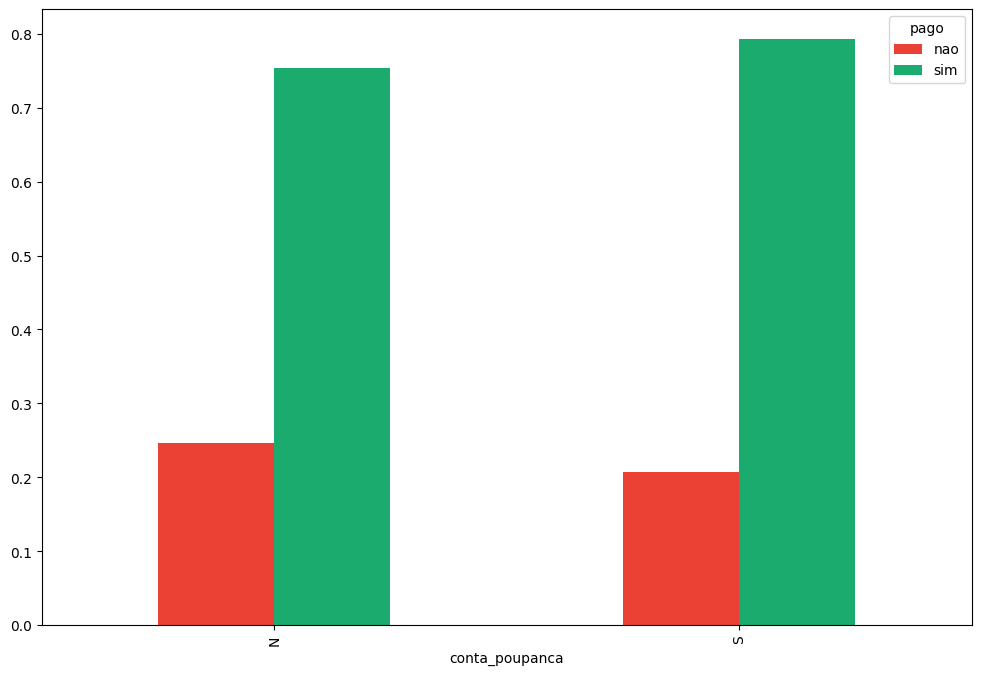

In [347]:
display(pd.crosstab(df6['conta_poupanca'], df6['pago']))

display(pd.crosstab(df6['conta_poupanca'], df6['pago'], normalize = 'index'))

display(pd.crosstab(df6['conta_poupanca'], df6['pago'], normalize = 'index')
        .plot(kind = 'bar', color = {'nao': '#eb4034' , 'sim': '#1bab6f'}));

#### 6.7. CHEQUE SEM FUNDO: Clientes que já passaram cheque sem fundo são em média 15% mais INADIMPLENTES (VERDADEIRA)

pago,nao,sim
cheque_sem_fundo,,
N,1051,9958
S,9290,28267


pago,nao,sim
cheque_sem_fundo,,
N,0.095467,0.904533
S,0.247357,0.752643


<Axes: xlabel='cheque_sem_fundo'>

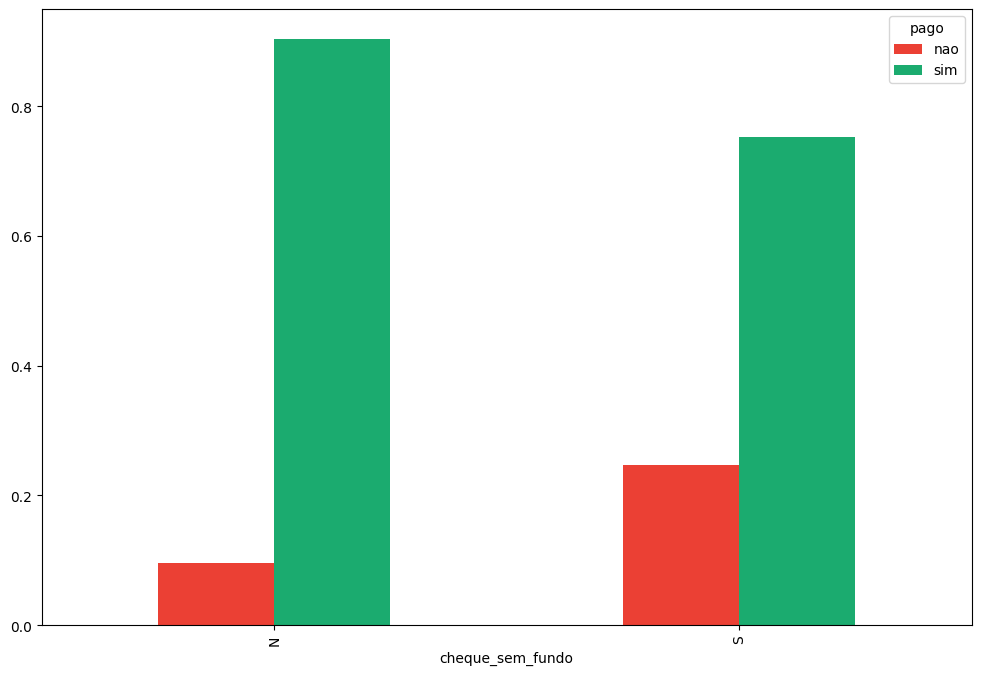

In [348]:
display(pd.crosstab(df6['cheque_sem_fundo'], df6['pago']))

display(pd.crosstab(df6['cheque_sem_fundo'], df6['pago'], normalize = 'index'))

display(pd.crosstab(df6['cheque_sem_fundo'], df6['pago'], normalize = 'index')
        .plot(kind = 'bar', color = {'nao': '#eb4034' , 'sim': '#1bab6f'}));

#### 6.8. CONTA CONJUNTA: Clientes que tem conta conjunta são em média 10% mais INADIMPLENTES (FALSA)

pago,nao,sim
conta_conjunta,,
N,10085,36489
S,256,1736


pago,nao,sim
conta_conjunta,,
N,0.216537,0.783463
S,0.128514,0.871486


<Axes: xlabel='conta_conjunta'>

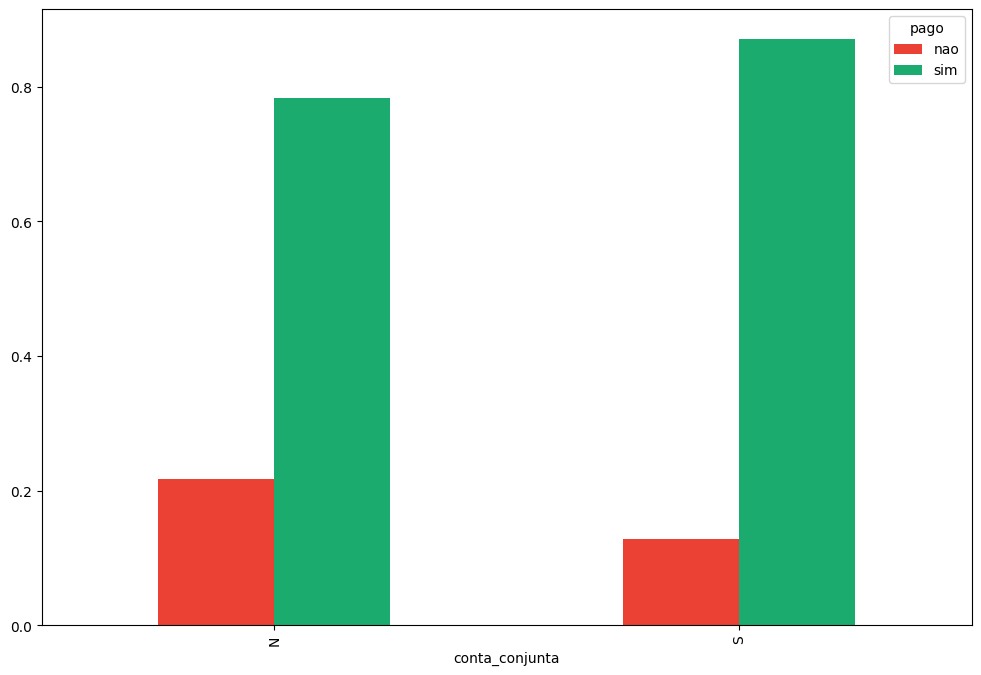

In [349]:
display(pd.crosstab(df6['conta_conjunta'], df6['pago']))

display(pd.crosstab(df6['conta_conjunta'], df6['pago'], normalize = 'index'))

display(pd.crosstab(df6['conta_conjunta'], df6['pago'], normalize = 'index')
        .plot(kind = 'bar', color = {'nao': '#eb4034' , 'sim': '#1bab6f'}));

#### 6.9. EMPRESTIMO: Clientes que pegaram empréstimos de mais de R$ 20.000,00 tem tendência a serem INADIMPLENTES (VERDADEIRA)

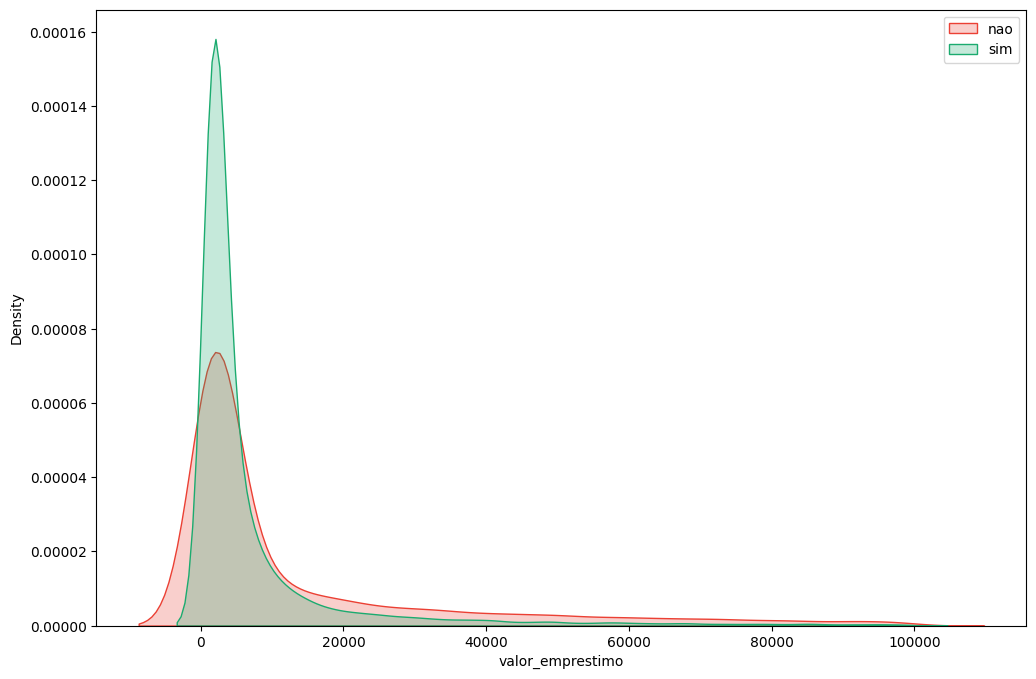

In [350]:
aux = df6[df6['valor_emprestimo'] < 100000].copy()

sns.kdeplot(aux[aux['pago'] == 'nao']['valor_emprestimo'], label ='nao', fill = True, color = '#eb4034')
sns.kdeplot(aux[aux['pago'] == 'sim']['valor_emprestimo'], label ='sim', fill = True, color = '#1bab6f')

plt.legend()

#### 6.10. UF: OS estados de RJ e SP tem maior percentual de clientes ADIMPLENTES do que ES e MG (FALSA)

pago,nao,sim
estado,,
espirito santo,2597,9550
minas gerais,2590,9612
rio de janeiro,2592,9483
sao paulo,2562,9580


pago,nao,sim
estado,,
espirito santo,0.213798,0.786202
minas gerais,0.212260,0.787740
rio de janeiro,0.214658,0.785342
sao paulo,0.211003,0.788997


<Axes: xlabel='estado'>

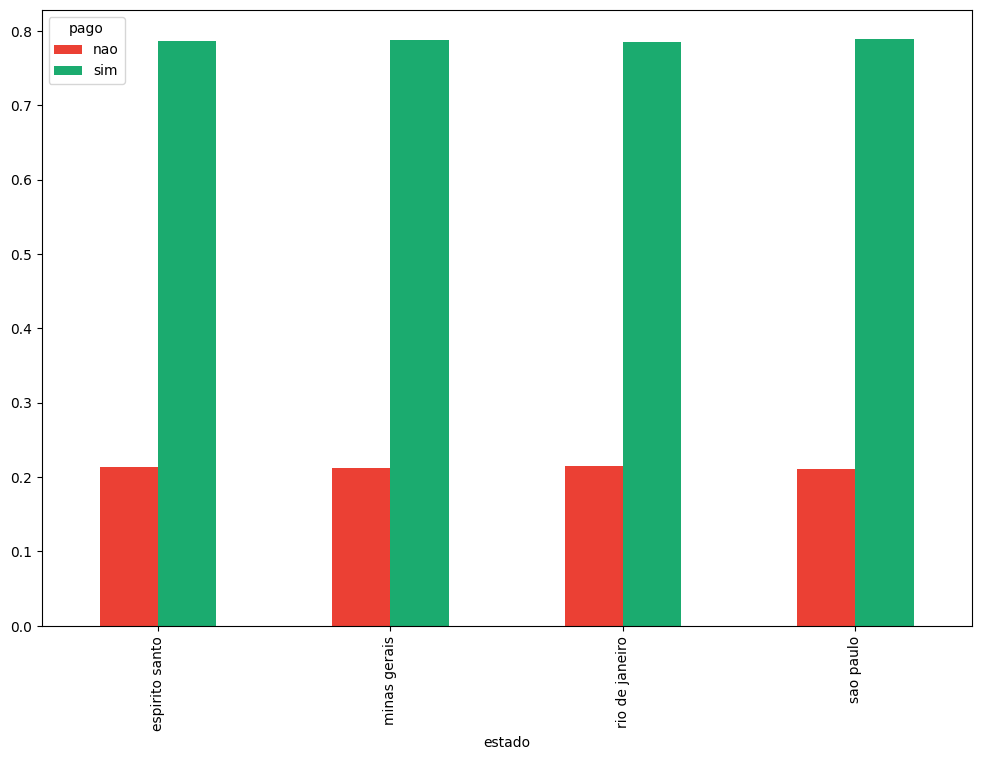

In [351]:
display(pd.crosstab(df6['estado'], df6['pago']))

display(pd.crosstab(df6['estado'], df6['pago'], normalize = 'index'))

display(pd.crosstab(df6['estado'], df6['pago'], normalize = 'index')
        .plot(kind = 'bar', color = {'nao': '#eb4034' , 'sim': '#1bab6f'}));

### 7.0 Análise de Correlação

In [352]:
df7 = df6.copy()

#### 7.1 Variáveis Numéricas

In [353]:
num_attributes = df7.select_dtypes(include = ['int32', 'int64', 
                                   'float32', 'float64'])

num_attributes = num_attributes.drop('id', axis = 1)

<Axes: >

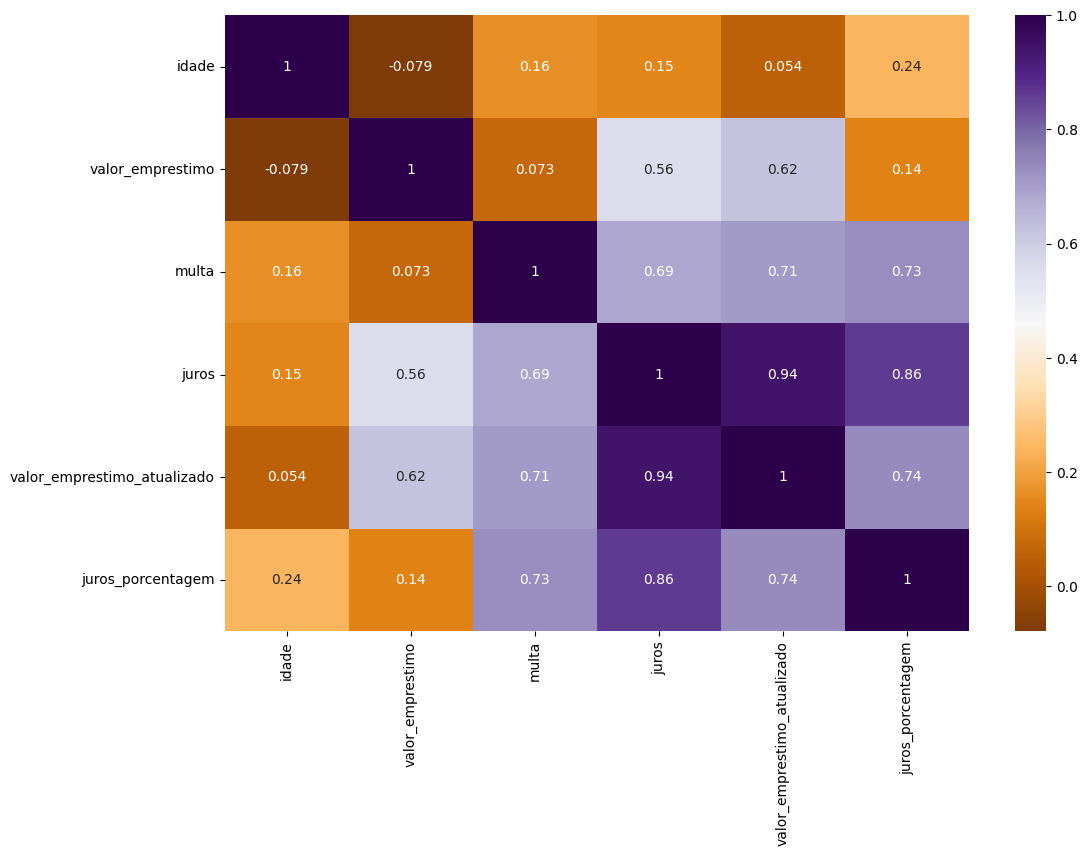

In [354]:
sns.heatmap(num_attributes.corr('spearman'), cmap = 'PuOr', annot = True)

<Axes: >

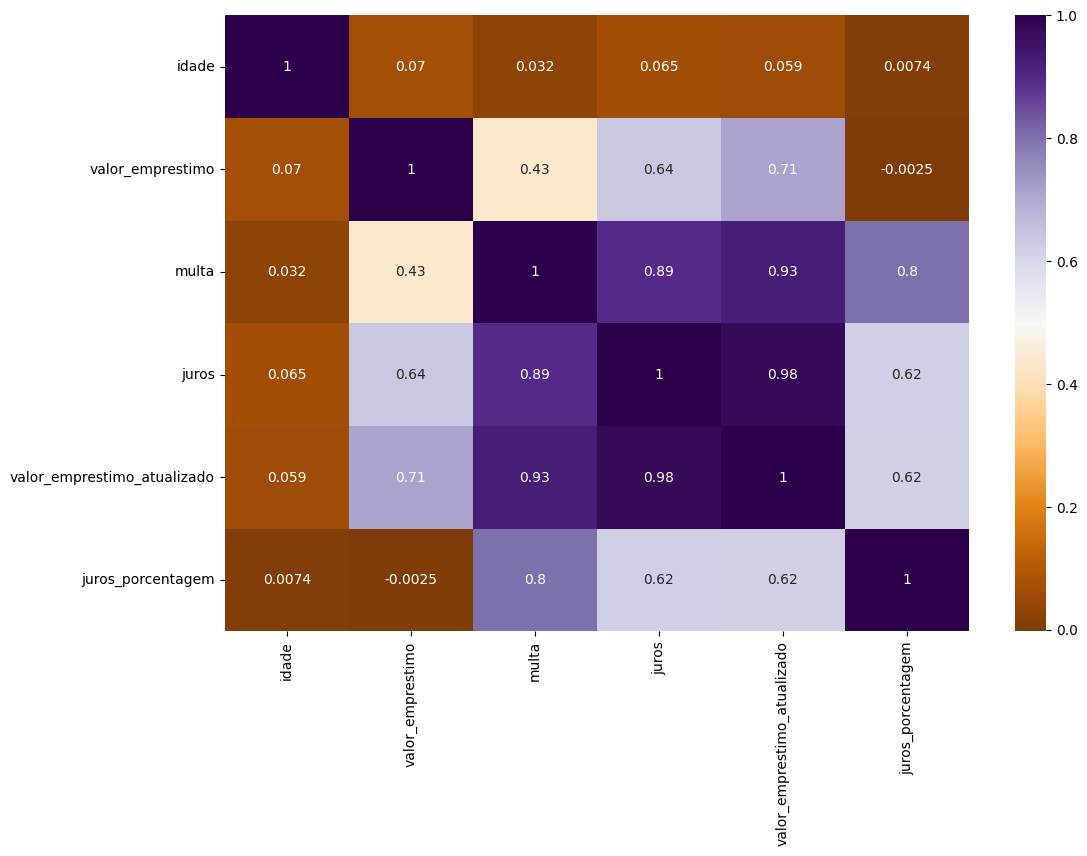

In [355]:
#relações lineares, distribuições normais

sns.heatmap(num_attributes.corr('pearson'), cmap = 'PuOr', annot = True)

#### 7.2 Variáveis Categóricas

In [356]:
cat_attributes = df7.select_dtypes(exclude = ['int32', 'int64', 
                                   'float32', 'float64', 'datetime64[ns]'])

In [357]:
cat_attributes_list = cat_attributes.columns.tolist()

corr_dict = {}

for i in range(len(cat_attributes_list)):
    corr_list = []

    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]

        #correlação
        confusion_matrix = pd.crosstab(cat_attributes[ref], cat_attributes[feat])
        corr = cramer_v(confusion_matrix.values)

        #inserindo na lista
        corr_list.append(corr)
        
    corr_dict[ref] = corr_list

In [358]:
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)

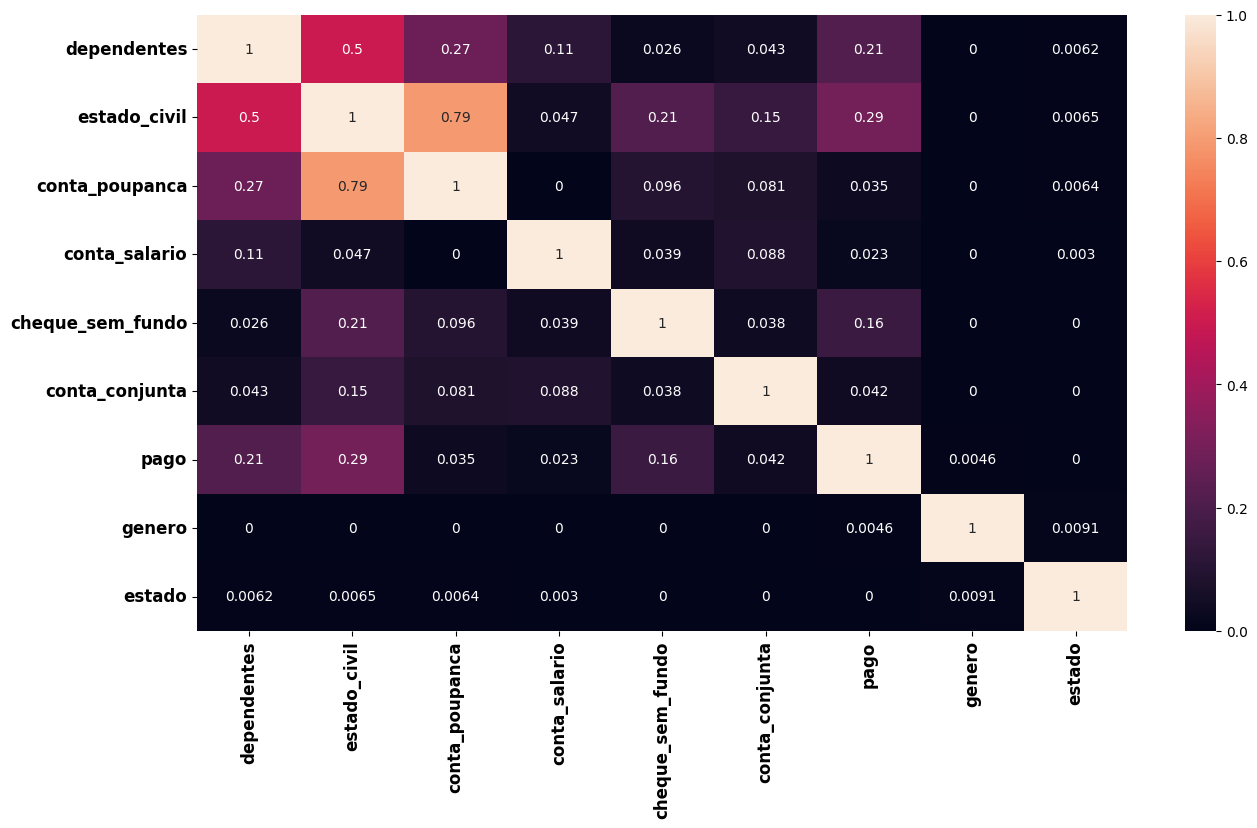

In [359]:

plt.figure(figsize=(15,8))
sns.heatmap(d, annot=True)

plt.xticks(rotation = 90, fontsize = 12, weight = 'bold')
plt.yticks(rotation = 360, fontsize = 12, weight = 'bold');

### 8.0 Modelagem dos Dados

In [360]:
df8 = pd.read_csv(config['data']['trusted_path'])

#### 8.1 Variável alvo: de categórica para numérica

In [361]:
df8['pago'] = df8['pago'].apply(label_pago)

#### 8.2 Divisão dos dados em treino e teste

In [362]:
train_set, test_set = train_test_split(df8, test_size = 0.2, 
                                       random_state = 42, 
                                       stratify = df8['pago'])

In [363]:
print(len(train_set))
print(len(test_set))

38852
9714


In [364]:
train_set.to_csv(config['data']['train_path'], index = False)
test_set.to_csv(config['data']['test_path'], index = False)

### 9.0 Seleção das Variáveis

In [365]:
df9 = pd.read_csv(config['data']['train_path']).drop(['id', 'multa', 'juros', 
                                                     'valor_emprestimo_atualizado', 
                                                     'juros_porcentagem'], axis = 1).copy()

In [366]:
df9.columns

Index(['dependentes', 'estado_civil', 'idade', 'conta_poupanca',
       'conta_salario', 'cheque_sem_fundo', 'conta_conjunta',
       'valor_emprestimo', 'pago', 'genero', 'estado'],
      dtype='str')

In [367]:
print(df9['pago'].value_counts(normalize=True))

pago
0    0.787064
1    0.212936
Name: proportion, dtype: float64


#### 9.1 Seleção de variáveis com Regressão Logística

In [368]:
columns_select = ['dependentes', 'estado_civil', 'idade', 
                  'conta_conjunta', 'cheque_sem_fundo', 
                  'valor_emprestimo', 'pago']

df9_lr = df9[columns_select].copy()

##### 9.1.1 Seleção pelo p-valor

###### 9.1.1.1 Ajustando a variável estado civil

In [369]:
df9_lr['estado_civil'].value_counts(normalize = True)

estado_civil
solteiro                                  0.537141
casado(a) com comunhao parcial de bens    0.270720
casado(a) com comunhao de bens            0.156646
casado(a) com separacao de bens           0.031092
separado judicialmente                    0.001519
divorciado                                0.001158
viuvo(a)                                  0.000927
outros                                    0.000798
Name: proportion, dtype: float64

In [370]:
#transformação da categoria estado_civil: 

ce_rare = RareLabelEncoder(n_categories=5,              #qtde máxima de categorias
                           tol=0.05,                    #percentual mínimo da categoria
                           variables=['estado_civil'],  #feature a ser transformada
                           replace_with = 'outros')     #nova categoria criada

ce_rare.fit(df9_lr)

df9_lr = ce_rare.transform(df9_lr)

ce_rare.encoder_dict_

{'estado_civil': ['solteiro',
  'casado(a) com comunhao parcial de bens',
  'casado(a) com comunhao de bens']}

In [371]:
df9_lr['estado_civil'].value_counts(normalize = True)

estado_civil
solteiro                                  0.537141
casado(a) com comunhao parcial de bens    0.270720
casado(a) com comunhao de bens            0.156646
outros                                    0.035494
Name: proportion, dtype: float64

###### 9.1.1.2 Balanceando os dados com reamostragem:

In [372]:
x_train, x_train_2, y_train, x_test, y_test = reamostrar_lr(df9_lr, 0.7)

pago
0    0.525829
1    0.474171
Name: proportion, dtype: float64


###### 9.1.1.3 Reescalando os dados

In [373]:
#métodos:
ss = StandardScaler()
yj = PowerTransformer(method = 'yeo-johnson', standardize = True)

#idade:
ss.fit(x_train_2[['idade']].values)
x_train_2['idade'] = ss.transform(x_train_2[['idade']])
x_test['idade'] = ss.transform(x_test[['idade']])

#valor do emprestimo:
yj.fit(x_train_2[['valor_emprestimo']].values)
x_train_2['valor_emprestimo'] = yj.transform(x_train_2[['valor_emprestimo']])
x_test['valor_emprestimo'] = yj.transform(x_test[['valor_emprestimo']])

/home/samanta/repos/shap_model/env_shap_model/lib/python3.11/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/samanta/repos/shap_model/env_shap_model/lib/python3.11/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/samanta/repos/shap_model/env_shap_model/lib/python3.11/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
/home/samanta/repos/shap_model/env_shap_model/lib/python3.11/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(


###### 9.1.1.4 Aplicando a Regressão Logística:

In [374]:
log_reg = smf.logit('''pago ~ valor_emprestimo + idade + estado_civil + 
                    conta_conjunta + dependentes + cheque_sem_fundo''', 
                    data = x_train_2).fit()

print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.596245
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   pago   No. Observations:                13957
Model:                          Logit   Df Residuals:                    13948
Method:                           MLE   Df Model:                            8
Date:                Mon, 23 Feb 2026   Pseudo R-squ.:                  0.1381
Time:                        21:35:00   Log-Likelihood:                -8321.8
converged:                       True   LL-Null:                       -9655.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept           

In [375]:
#verificando a performance da Regressão Logística:

y_hat_lr = log_reg.predict(x_test)
predictions = list(map(round, y_hat_lr))

cm = metrics.confusion_matrix(y_test, predictions)

print('Confusion Matrix: \n', cm)

Confusion Matrix: 
 [[4450 1666]
 [ 588 1067]]


##### 9.1.2 Seleção de variáveis com KBEST ANOVA (Regressão Logística)

In [376]:
#lendo os dados:
df9 = pd.read_csv(config['data']['train_path']).drop(['id', 'multa', 'juros', 'valor_emprestimo_atualizado', 'juros_porcentagem'], axis=1).copy()

columns_select = ['dependentes', 'estado_civil', 'idade', 'conta_conjunta', 'cheque_sem_fundo', 'valor_emprestimo', 'pago']

df9_lr = df9[columns_select].copy()

In [377]:
#divisão em treino e teste:

x_train, x_test, y_train, y_test  = train_test_split(df9_lr.drop('pago',axis=1), 
                                                     df9_lr['pago'],
                                                     test_size = 0.2, 
                                                     random_state = 42, 
                                                     stratify = df9_lr['pago'])

In [378]:
#reescala e transformação dos dados:

#idade:
ss = StandardScaler()
ss.fit(x_train[['idade']].values)
x_train['idade'] = ss.transform(x_train[['idade']])
x_test['idade'] = ss.transform(x_test[['idade']])

#valor_emprestimo:
yj = PowerTransformer(method='yeo-johnson', standardize=True)
yj.fit(x_train[['valor_emprestimo']].values)
x_train['valor_emprestimo'] = yj.transform(x_train[['valor_emprestimo']])
x_test['valor_emprestimo'] = yj.transform(x_test[['valor_emprestimo']])

#estado_civil:
ce_rare = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')
ce_rare.fit(x_train)
x_train = ce_rare.transform(x_train)
x_test = ce_rare.transform(x_test)

#variáveis categóricas:
ce_OHE = OneHotEncoder( variables = ['conta_conjunta', 'dependentes', 'estado_civil', 'cheque_sem_fundo'], drop_last = True).fit(x_train)
x_train = ce_OHE.transform(x_train)
x_test = ce_OHE.transform(x_test)

/home/samanta/repos/shap_model/env_shap_model/lib/python3.11/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/samanta/repos/shap_model/env_shap_model/lib/python3.11/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/samanta/repos/shap_model/env_shap_model/lib/python3.11/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
/home/samanta/repos/shap_model/env_shap_model/lib/python3.11/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(


TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'variables'

k= 1 0 F1_0 = 0.823 - F1_1 = 0.433
k= 2 0 F1_0 = 0.718 - F1_1 = 0.447
k= 3 0 F1_0 = 0.731 - F1_1 = 0.45
k= 4 0 F1_0 = 0.753 - F1_1 = 0.462
k= 5 0 F1_0 = 0.768 - F1_1 = 0.48
k= 6 0 F1_0 = 0.768 - F1_1 = 0.479
k= 7 0 F1_0 = 0.773 - F1_1 = 0.481
k= 8 0 F1_0 = 0.772 - F1_1 = 0.478


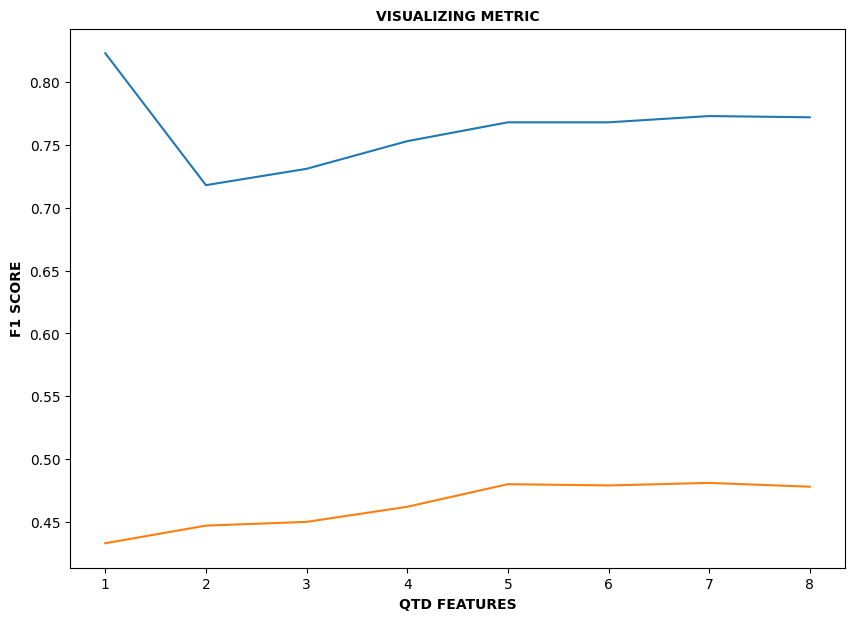

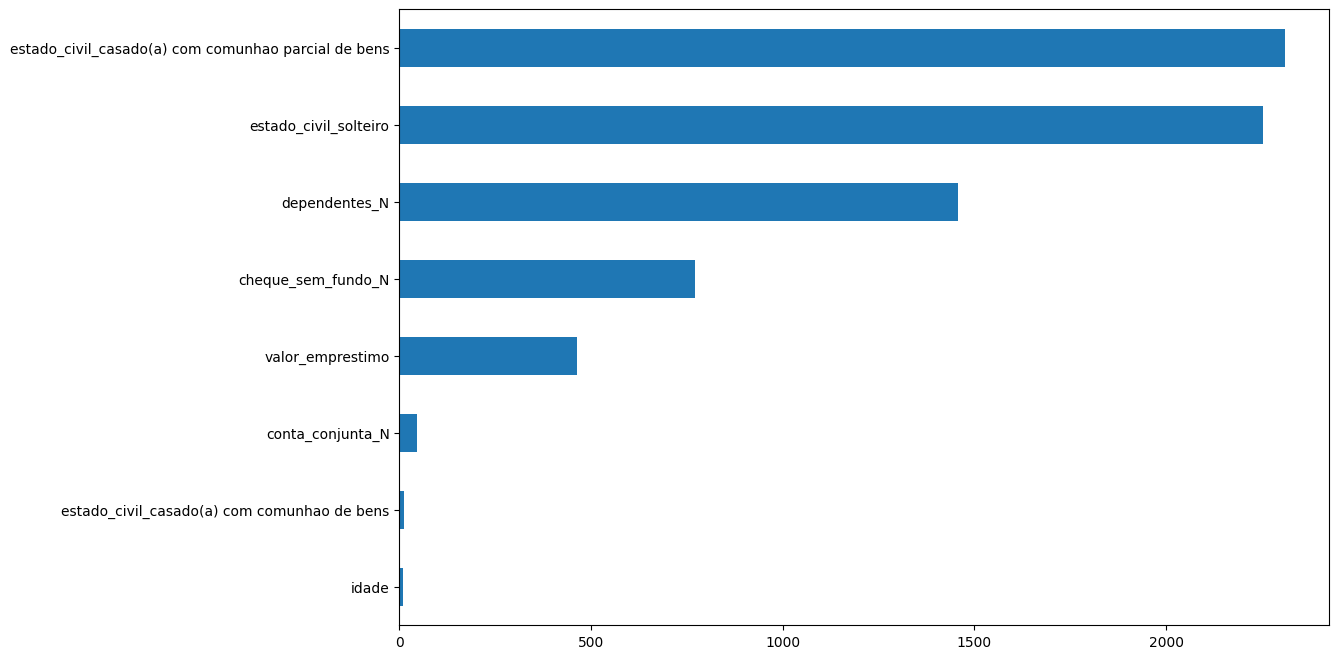

,variavel,fs_score,p_value
0,estado_civil_casado(a) com comunhao parcial de...,2310.296370,0.000000e+00
1,estado_civil_solteiro,2252.493119,0.000000e+00
2,dependentes_N,1457.194867,0.000000e+00
3,cheque_sem_fundo_N,770.260255,1.747998e-167
4,valor_emprestimo,463.627909,4.356658e-102
5,conta_conjunta_N,45.178405,1.829841e-11
6,estado_civil_casado(a) com comunhao de bens,11.793905,5.950249e-04
7,idade,9.240297,2.369434e-03


In [ ]:
fs_kbest(x_train, y_train, x_test, y_test, model = LogisticRegression(class_weight='balanced'))

#### 9.2 Seleção de variáveis com Decision Tree

##### 9.2.1 Recursive Feature Addition

In [ ]:
columns_select = ['dependentes', 'estado_civil', 'idade',
                  'cheque_sem_fundo', 'conta_conjunta',
                  'valor_emprestimo', 'pago']

df9_dt = df9[columns_select].copy()

In [ ]:
x_train, x_test, y_train, y_test  = train_test_split(df9_dt.drop('pago',axis=1), 
                                                     df9_dt['pago'],
                                                     test_size = 0.2, 
                                                     random_state = 42, 
                                                     stratify = df9_dt['pago'])

In [ ]:
#Transformação dos dados:

#estado_civil:
ce_rare = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')
ce_rare.fit(x_train)
x_train = ce_rare.transform(x_train)
x_test = ce_rare.transform(x_test)

#variáveis categóricas:
ce_mean = MeanEncoder(variables = ['conta_conjunta', 'dependentes', 'estado_civil', 'cheque_sem_fundo']).fit(x_train, y_train)
x_train = ce_mean.transform(x_train)
x_test = ce_mean.transform(x_test)

/home/samanta/repos/shap_model/env_shap_model/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable estado_civil is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(


In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

estimator = DecisionTreeClassifier(class_weight='balanced', 
                                   random_state=42,
                                    max_depth= 5 )

rfa = RecursiveFeatureAddition(estimator, scoring = 'roc_auc', cv = kf, threshold = 0.005, confirm_variables = False)
rfa.fit_transform(x_train, y_train)

,dependentes,estado_civil,cheque_sem_fundo,valor_emprestimo
38633,0.277664,0.114152,0.09542,10946.00
15255,0.277664,0.114152,0.24742,2898.91
22547,0.277664,0.231518,0.24742,1501.00
14271,0.096983,0.114152,0.24742,3169.21
29288,0.096983,0.114152,0.24742,7989.45
...,...,...,...,...
852,0.277664,0.114152,0.24742,1569.00
27337,0.096983,0.114152,0.09542,2630.11
19111,0.277664,0.231518,0.24742,54697.40
37121,0.096983,0.114152,0.09542,1866.15


##### 9.2.2 Feature Importance

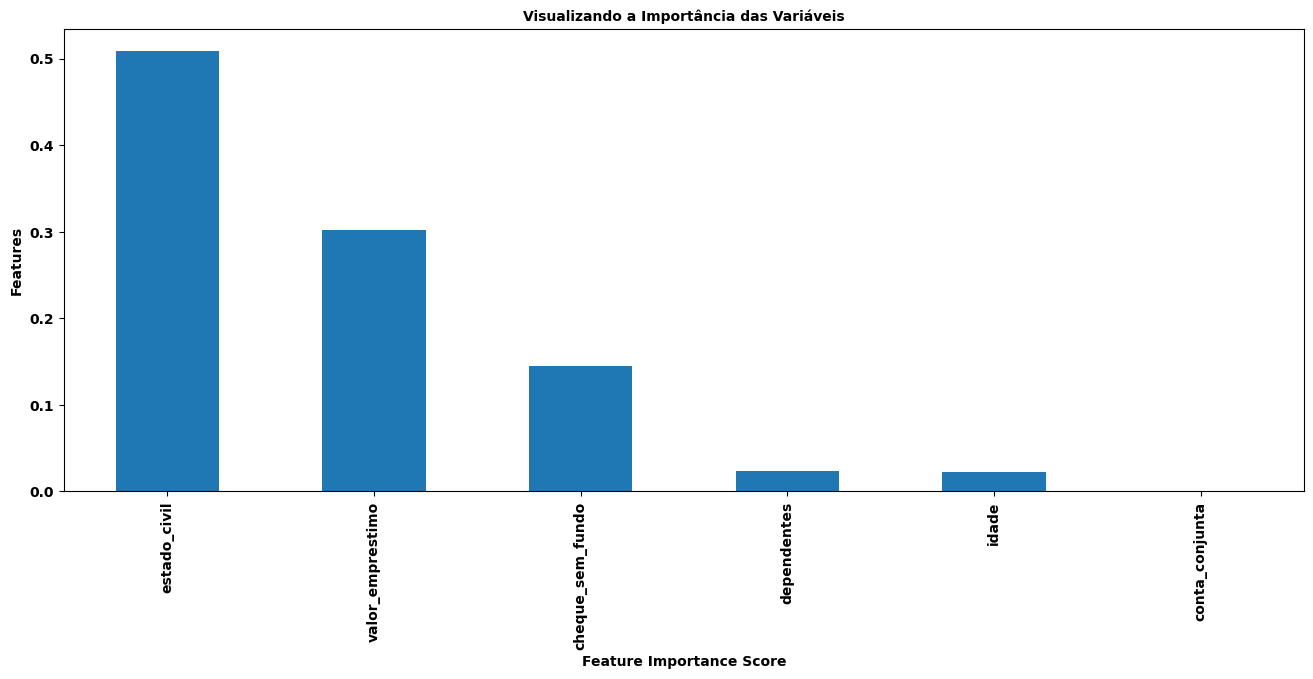

In [ ]:
estimator = DecisionTreeClassifier(class_weight='balanced', 
                                   random_state=42,
                                    max_depth= 5 ).fit(x_train, y_train)

features = pd.Series(estimator.feature_importances_)
features.index = x_train.columns

features.sort_values(ascending = False, inplace = True)

features.plot.bar(figsize = (16,6))

plt.xlabel('Feature Importance Score',fontsize = 10, weight = 'bold')
plt.ylabel('Features',fontsize = 10, weight = 'bold')

plt.title('Visualizando a Importância das Variáveis', fontsize = 10, weight = 'bold')

plt.xticks(fontsize = 10, weight = 'bold')
plt.yticks(fontsize = 10, weight = 'bold')

plt.show()

#### 9.3 Seleção de variáveis com Random Forest

##### 9.3.1 RFA

In [379]:
columns_select = ['dependentes', 'estado_civil', 'idade',
                  'cheque_sem_fundo', 'conta_conjunta',
                  'valor_emprestimo', 'pago']

df9_rf = df9[columns_select].copy()

In [380]:
x_train, x_test, y_train, y_test  = train_test_split(df9_rf.drop('pago',axis=1), 
                                                     df9_rf['pago'],
                                                     test_size = 0.2, 
                                                     random_state = 42, 
                                                     stratify = df9_rf['pago'])

In [381]:
#Transformação dos dados:

#estado_civil:
ce_rare = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')
ce_rare.fit(x_train)
x_train = ce_rare.transform(x_train)
x_test = ce_rare.transform(x_test)

#variáveis categóricas:
ce_mean = MeanEncoder(variables = ['conta_conjunta', 'dependentes', 'estado_civil', 'cheque_sem_fundo']).fit(x_train, y_train)
x_train = ce_mean.transform(x_train)
x_test = ce_mean.transform(x_test)

In [382]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

estimator = RandomForestClassifier(class_weight='balanced', 
                                   random_state=42,
                                   max_depth= 5 )

rfa = RecursiveFeatureAddition(estimator, scoring = 'roc_auc', cv = kf, threshold = 0.005, confirm_variables = False)
rfa.fit_transform(x_train, y_train)

,dependentes,estado_civil,cheque_sem_fundo,valor_emprestimo
38633,0.277664,0.114152,0.09542,10946.00
15255,0.277664,0.114152,0.24742,2898.91
22547,0.277664,0.231518,0.24742,1501.00
14271,0.096983,0.114152,0.24742,3169.21
29288,0.096983,0.114152,0.24742,7989.45
...,...,...,...,...
852,0.277664,0.114152,0.24742,1569.00
27337,0.096983,0.114152,0.09542,2630.11
19111,0.277664,0.231518,0.24742,54697.40
37121,0.096983,0.114152,0.09542,1866.15


##### 9.3.2 Feature Importance

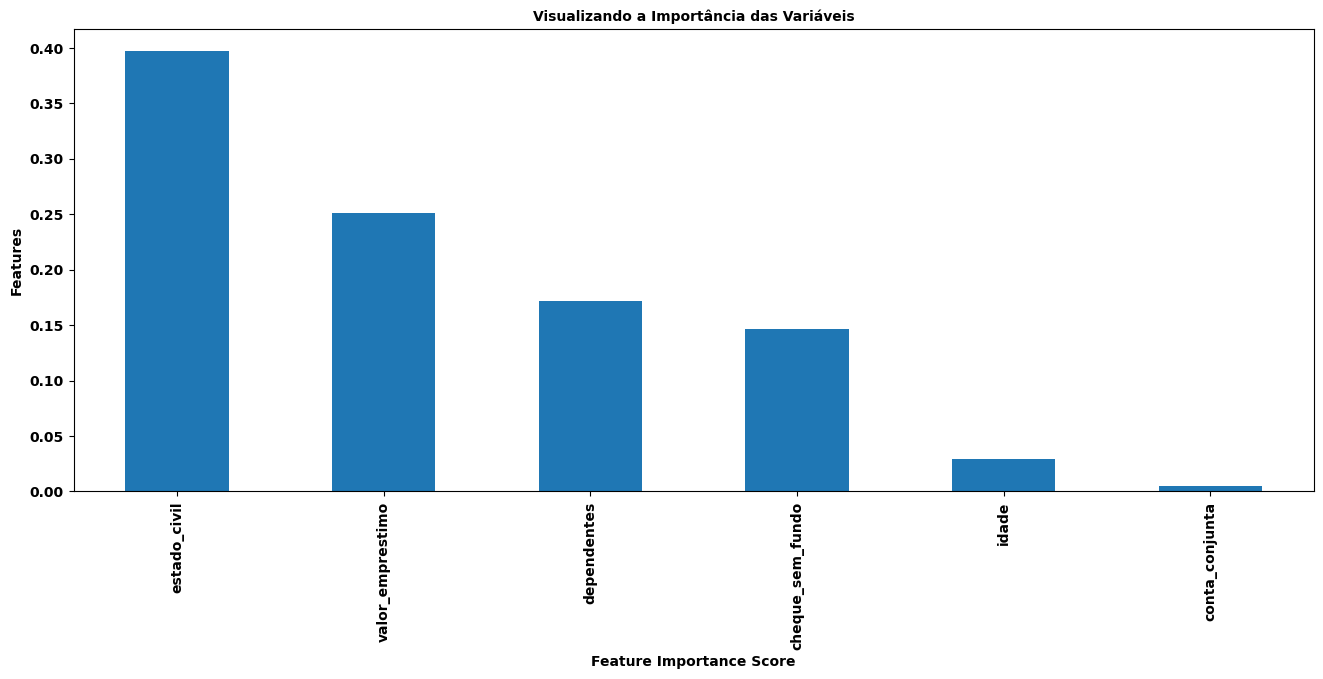

In [383]:
estimator = RandomForestClassifier(class_weight='balanced', 
                                   random_state=42,
                                   max_depth= 5 ).fit(x_train, y_train)

features = pd.Series(estimator.feature_importances_)
features.index = x_train.columns

features.sort_values(ascending = False, inplace = True)

features.plot.bar(figsize = (16,6))

plt.xlabel('Feature Importance Score',fontsize = 10, weight = 'bold')
plt.ylabel('Features',fontsize = 10, weight = 'bold')

plt.title('Visualizando a Importância das Variáveis', fontsize = 10, weight = 'bold')

plt.xticks(fontsize = 10, weight = 'bold')
plt.yticks(fontsize = 10, weight = 'bold')

plt.show()

### 10.0 Pipeline de ML e avaliação do desempenho do modelo

#### 10.1 Regressão Logística

In [384]:
df10_lr = df9 = pd.read_csv(config['data']['train_path']).copy()

columns_select = ['dependentes', 'estado_civil', 'cheque_sem_fundo', 'valor_emprestimo', 'pago']

df10_lr = df10_lr[columns_select].copy()

##### 10.1.1 Pipeline

In [385]:
categorical_features = ['dependentes', 'cheque_sem_fundo', 'estado_civil']
numeric_features = ['valor_emprestimo']

categorical_pipeline = Pipeline(steps=[
    ('rare_label', RareLabelEncoder(
        n_categories=5,
        tol=0.05,
        variables=['estado_civil'],
        replace_with='outros'
    )),
    ('onehot', OneHotEncoder(
        drop='first',
        handle_unknown='ignore',
        sparse_output=False
    ))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_pipeline, categorical_features),
        ('num', PowerTransformer(method='yeo-johnson'), numeric_features)
    ],
    remainder='drop'
)

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        random_state=42,
        class_weight='balanced',
        n_jobs=1
    ))
])

##### 10.1.2 Treino e Métricas de validação

In [ ]:
def cv_clf_metrics(model, df, target, cv, model_name, search=False):

In [392]:
lr_result = cv_clf_metrics(model = clf, df = df10_lr, target = 'pago', cv = kf, model_name = 'Logistic Regression', search=False)

/home/samanta/repos/shap_model/env_shap_model/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
/home/samanta/repos/shap_model/env_shap_model/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
/home/samanta/repos/shap_model/env_shap_model/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
/home/samanta/repos/shap_model/env_shap_model/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarnin

TRAIN DATA
accuracy          : [0.682, 0.696, 0.694, 0.683, 0.684] / media: 0.688 / std: 0.006
balanced_accuracy : [0.687, 0.688, 0.687, 0.688, 0.687] / media: 0.687 / std: 0.001
precision_0       : [0.892, 0.888, 0.889, 0.892, 0.891] / media: 0.89 / std: 0.001
precision_1       : [0.369, 0.38, 0.378, 0.37, 0.37] / media: 0.373 / std: 0.004
recall_0          : [0.679, 0.702, 0.698, 0.68, 0.682] / media: 0.688 / std: 0.01
recall_1          : [0.695, 0.674, 0.676, 0.696, 0.691] / media: 0.686 / std: 0.009
f1_0              : [0.771, 0.784, 0.782, 0.771, 0.773] / media: 0.776 / std: 0.006
f1_1              : [0.482, 0.486, 0.485, 0.483, 0.482] / media: 0.484 / std: 0.001
roc_auc           : [0.747, 0.746, 0.745, 0.745, 0.745] / media: 0.746 / std: 0.001

------------------------------------------------------------------------------------------

TEST DATA
accuracy          : [0.688, 0.688, 0.699, 0.675, 0.684] / media: 0.687 / std: 0.008
balanced_accuracy : [0.686, 0.677, 0.689, 0.686, 0.6

,Model Name,Accuracy CV,Balanced Accuracy CV,ROC AUC CV,F1 Class 0 CV,F1 Class 1 CV,Precision Class 0 CV,Precision Class 1 CV,Recall Class 0 CV,Recall Class 1 CV
0,Logistic Regression,0.687 +/- 0.008,0.686 +/- 0.005,0.745 +/- 0.003,0.776 +/- 0.008,0.482 +/- 0.005,0.89 +/- 0.004,0.372 +/- 0.006,0.687 +/- 0.014,0.685 +/- 0.019
